### Analysis

In [1]:
!pip install mat73 >> None
!pip install filters >> None
!pip install measure >> None
!pip install segmentation >> None

In [2]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import OrderedDict

from skimage import io
from skimage.measure import regionprops,find_contours
from skimage.segmentation import join_segmentations
from sklearn.metrics.pairwise import euclidean_distances

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dict_smoothed = mat73.loadmat('/content/drive/MyDrive/ColabNotebooks/smoothed_video.mat')
struct = data_dict_smoothed['smoothed_video']

In [4]:
import pywt
def intensity_mean (struct, segment_size=1024, threshold=20):
    bright_mean_per_frame = []
    for frame in range (1200):
        I=struct[0:segment_size, 0:segment_size, frame]>=threshold
        bright_mean_per_frame.append(np.mean(struct[0:segment_size, 0:segment_size, frame][I]))
    return bright_mean_per_frame

def intensity_distribution (struct):
    flat_struct_0 = struct[:, :, 0].flatten()
    flat_struct_800 = struct[:, :, 880].flatten()
    qauntile_0_95 = np.quantile(flat_struct_0, 0.95)
    print ('quantile 0.95', qauntile_0_95)

    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,10])
    ax1.hist(flat_struct_0, bins=100, log=True)
    ax2.hist(flat_struct_800, bins=100, log=True)

    ax1.set_xlabel('Intensity, 0 frame')
    ax1.set_ylabel('number of pixels')
    ax2.set_xlabel('Intensity, 800 frame')
    ax2.set_ylabel('number of pixels')
    plt.savefig("fig1.png")
    fig1 = plt.show()
    return fig1, qauntile_0_95

def intensity_per_frame (bright_mean_per_frame):
    plt.plot(bright_mean_per_frame)
    plt.xlabel('frames')
    plt.ylabel('Intensity')
    plt.savefig("fig2.png")
    fig2 = plt.show()
    return fig2

def segment_frame(frame, segment_size):
    segments = []
    for i in range(0, 1024, segment_size):
        for j in range(0, 1024, segment_size):
            segment = frame[i:i+segment_size, j:j+segment_size]
            segments.append(segment)
    return segments

In [ ]:
segment_size = 256
thresholds = [-7, 0, 10, 25, 50, 70, 90, 110, 130, 143]
segments = segment_frame(struct, segment_size)
for threshold in thresholds:
    mean_intensity = intensity_mean(struct, 1024, threshold)
    max_level = pywt.dwt_max_level(data_len=len(mean_intensity), filter_len=pywt.Wavelet('db4').dec_len)
    coeffs_multilevel = pywt.wavedec(mean_intensity, 'db4', level=max_level)
    plt.figure(figsize=(15, 2 * max_level))
    for i in range(1, max_level + 1):
        plt.subplot(max_level, 1, i)
        plt.plot(coeffs_multilevel[-i], label=f'Level {i}')
        plt.title(f'Wavelet Decomposition Level {i} for Treshold {threshold}')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f'Wavelet Decomposition for Treshold {threshold}')
    plt.show()

for segment in range(len(segments)):
    for threshold in thresholds:
        mean_intensity = intensity_mean(segments[segment], segment_size, threshold)
        max_level = pywt.dwt_max_level(data_len=len(mean_intensity), filter_len=pywt.Wavelet('db4').dec_len)

        coeffs_multilevel = pywt.wavedec(mean_intensity, 'db4', level=max_level)

        plt.figure(figsize=(15, 2 * max_level))
        for i in range(1, max_level + 1):
            plt.subplot(max_level, 1, i)
            plt.plot(coeffs_multilevel[-i], label=f'Level {i}')
            plt.title(f'Wavelet Decomposition Level {i} for Treshold {threshold} for Segment {segment}')
            plt.legend()

        plt.tight_layout()
        plt.savefig(f'Wavelet Decomposition for Treshold {threshold} for Segment {segment}')
        plt.show()

#first_frame = struct[:, :, 0]
#plt.imshow(first_frame)
#plt.title('Первый кадр')
#plt.show()



struct min -7.10269
struct max 143.80998
quantile 0.95 18.89964008331299


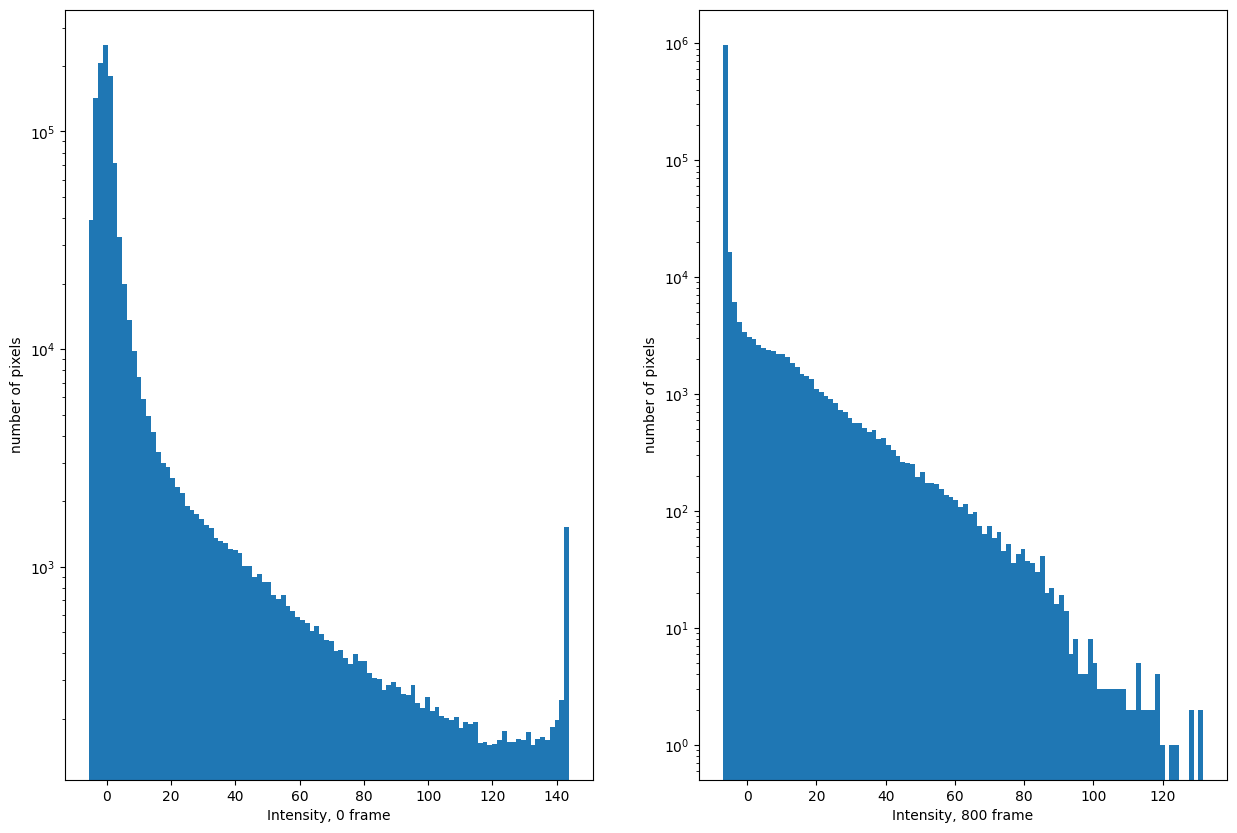

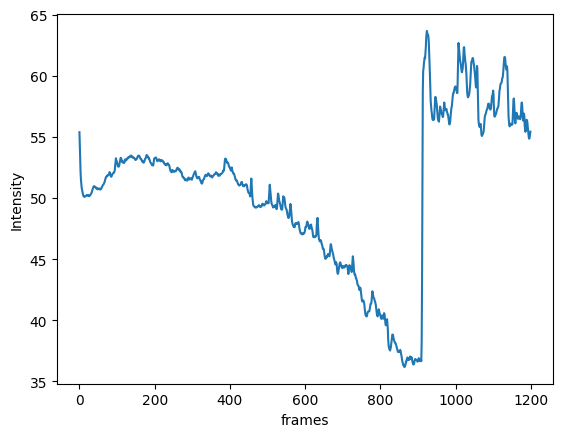

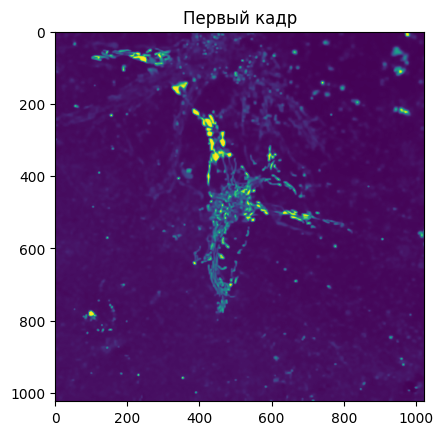

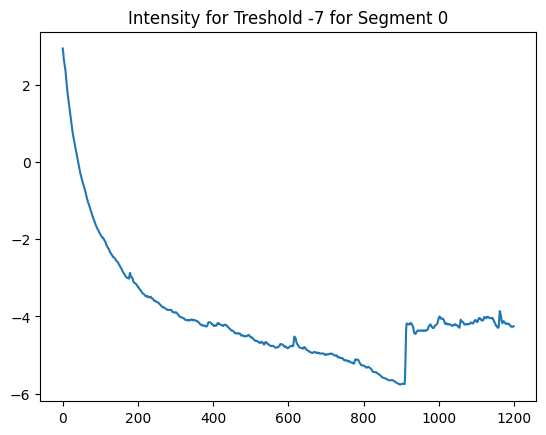

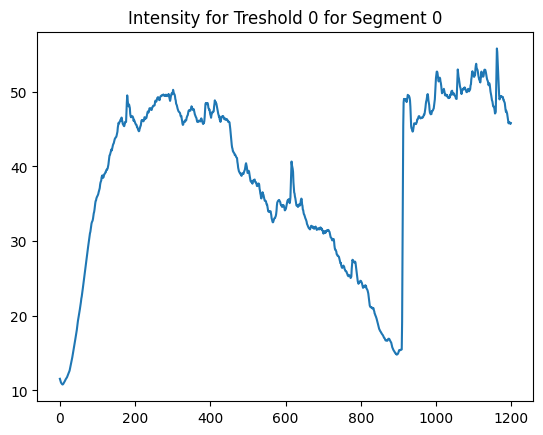

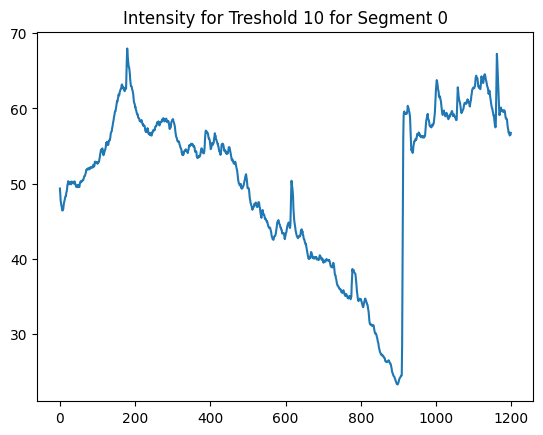

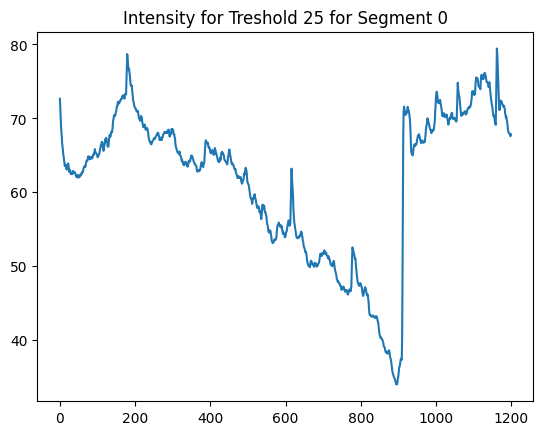

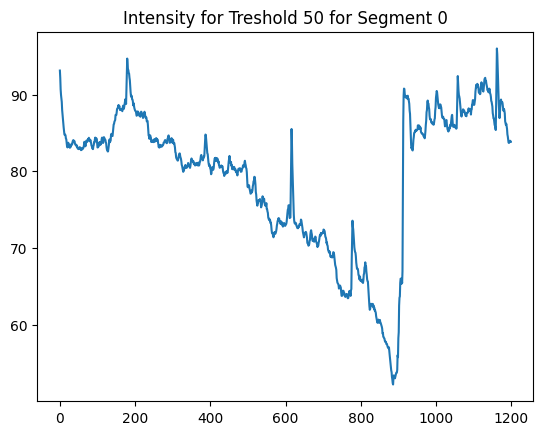

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


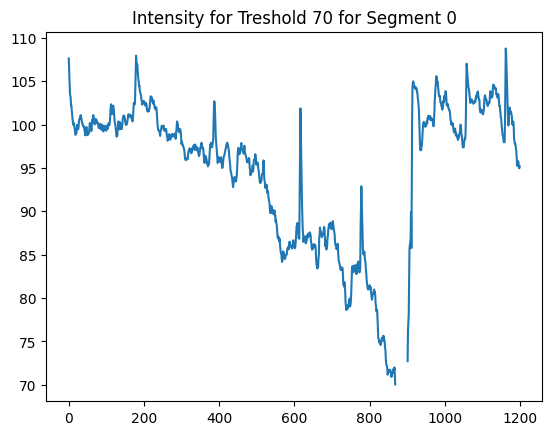

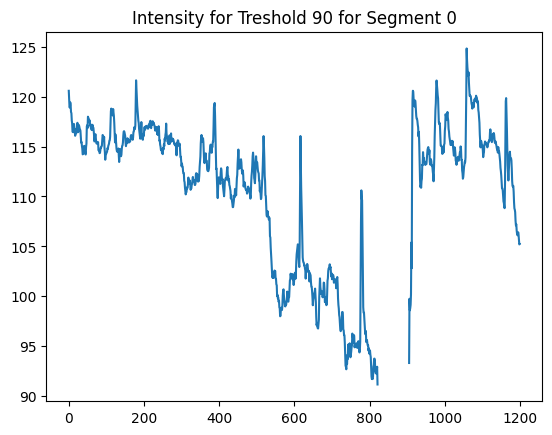

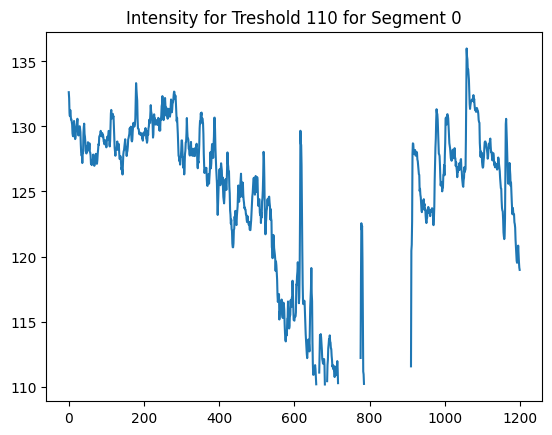

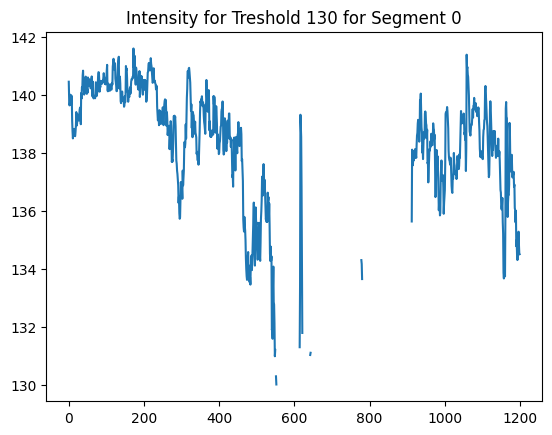

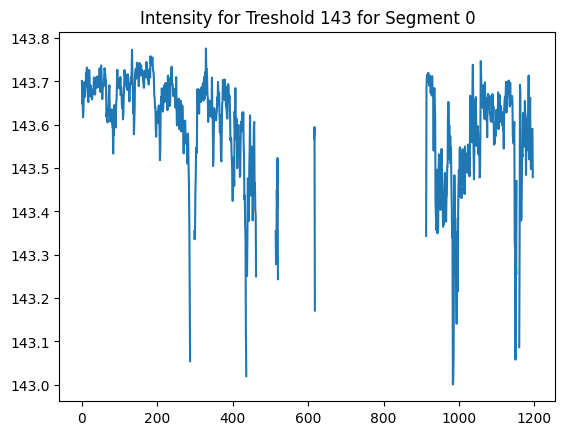

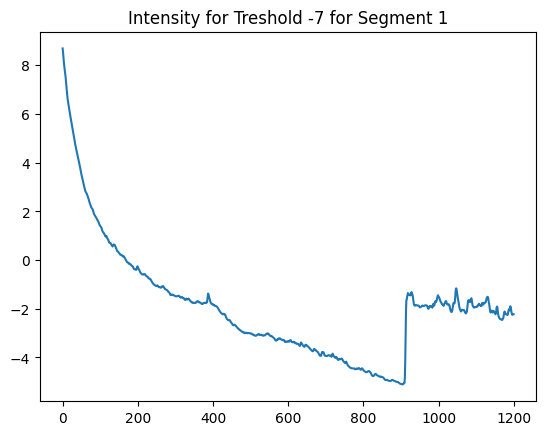

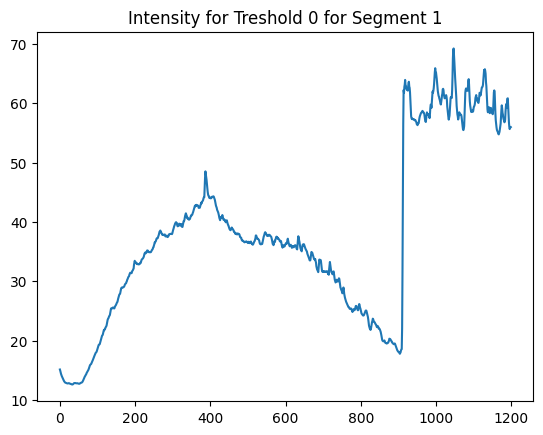

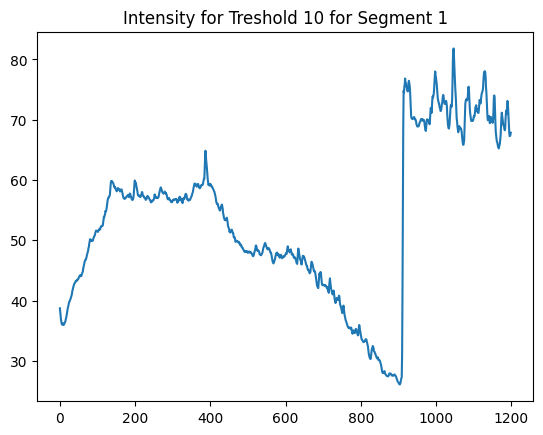

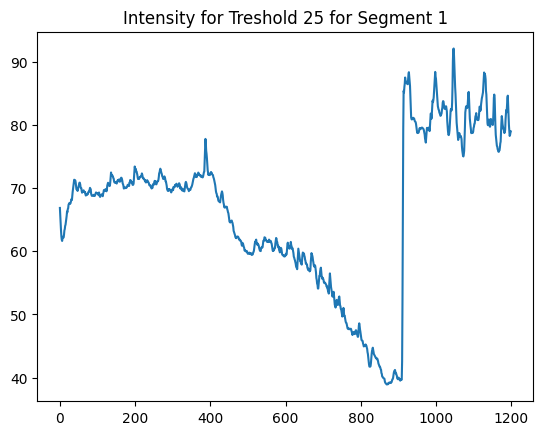

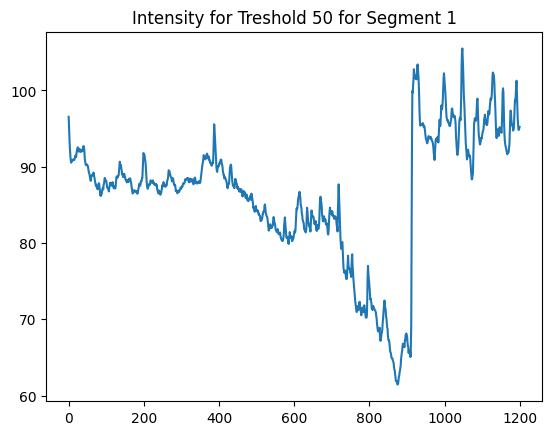

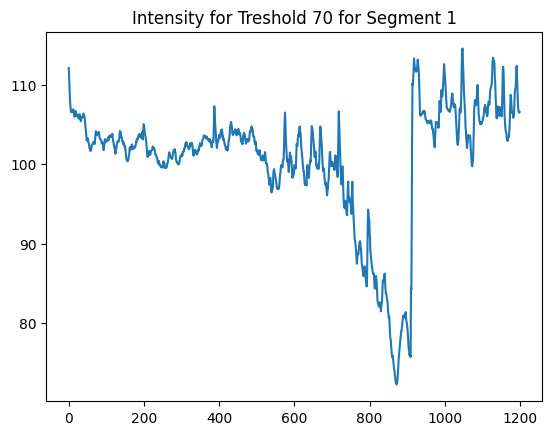

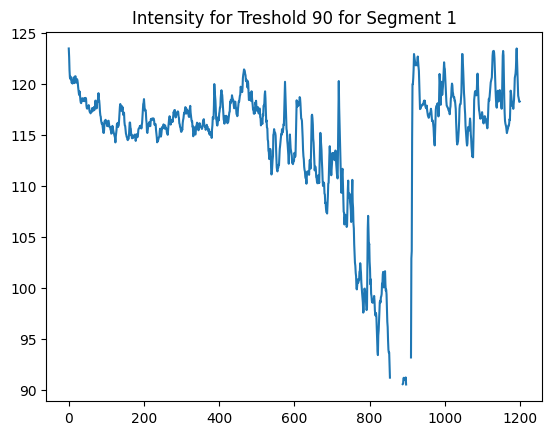

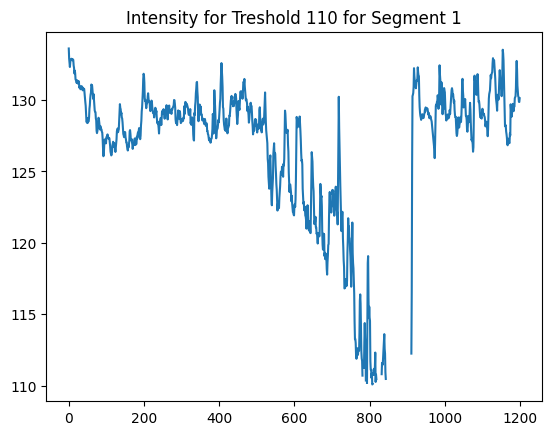

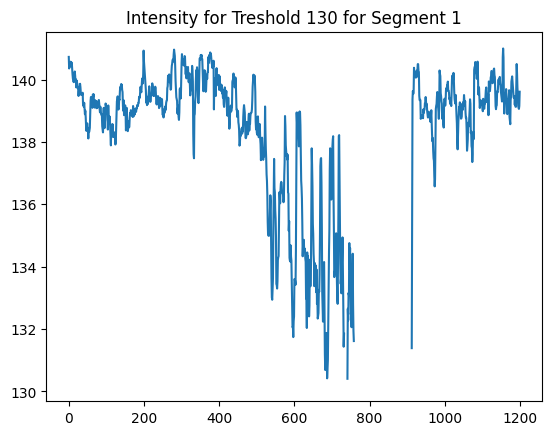

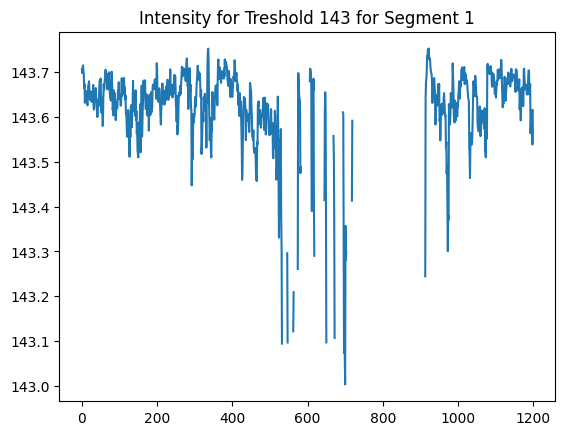

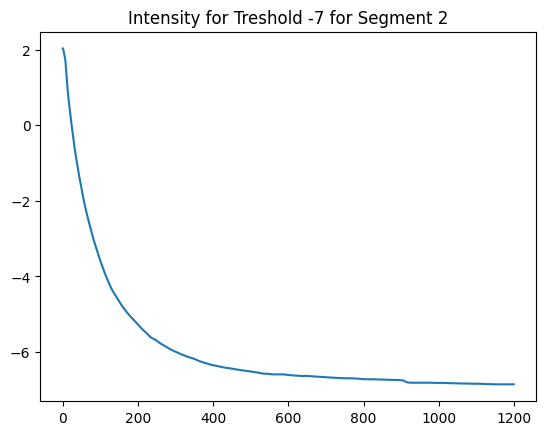

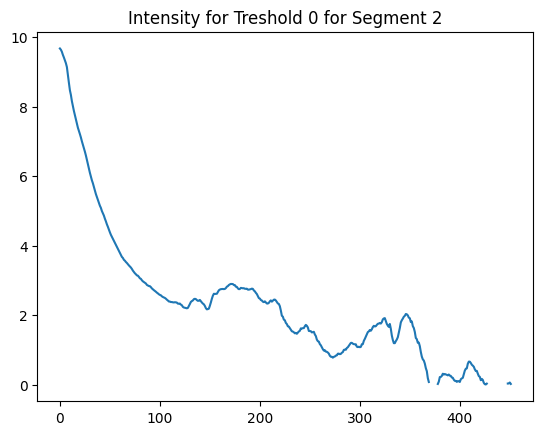

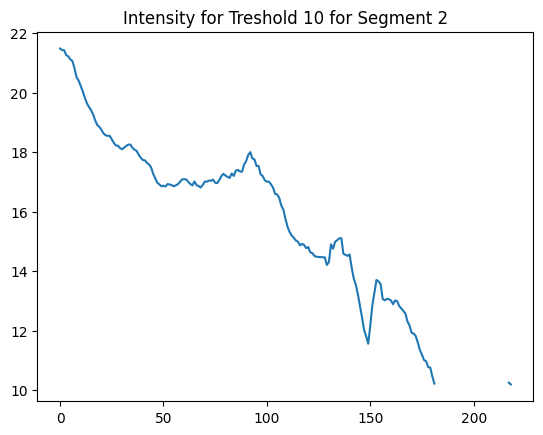

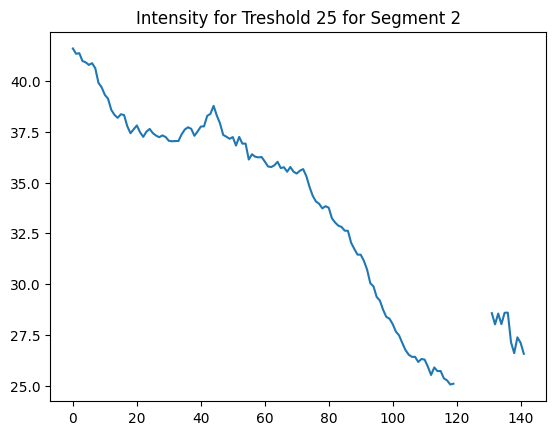

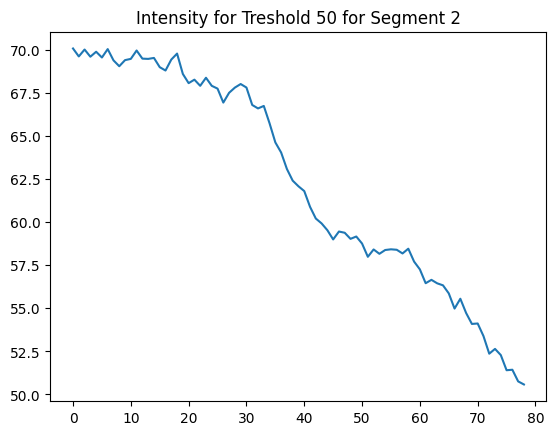

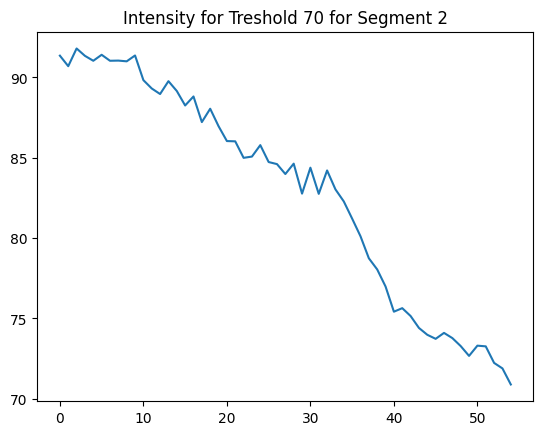

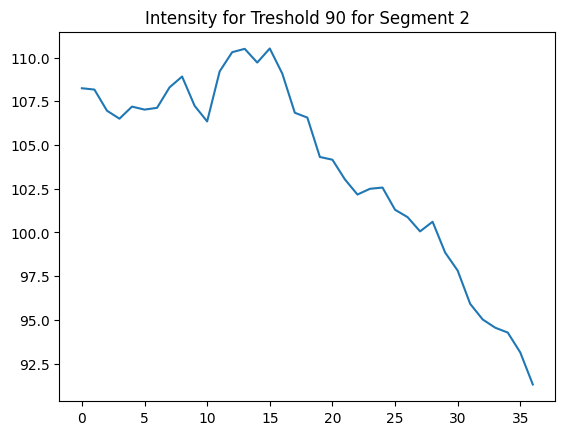

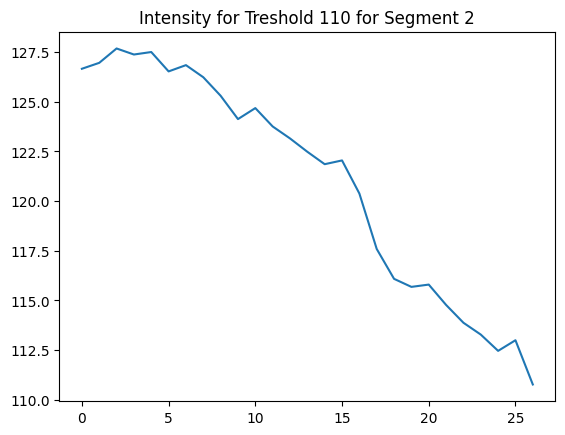

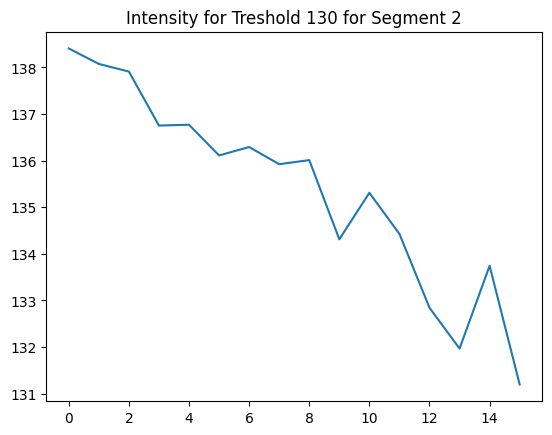

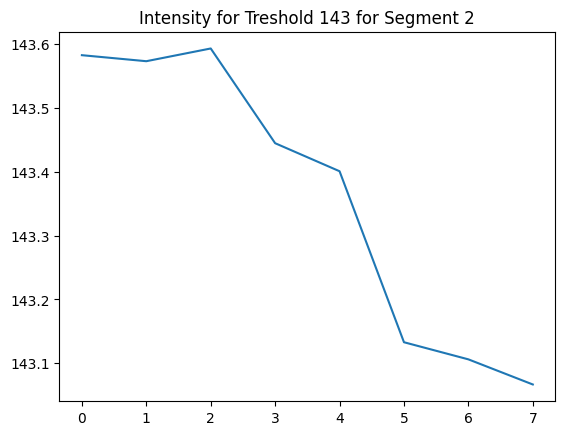

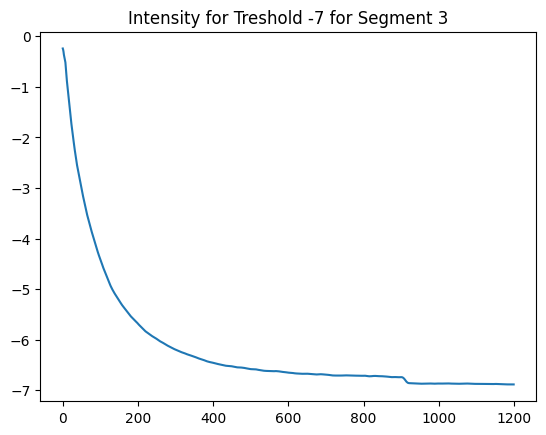

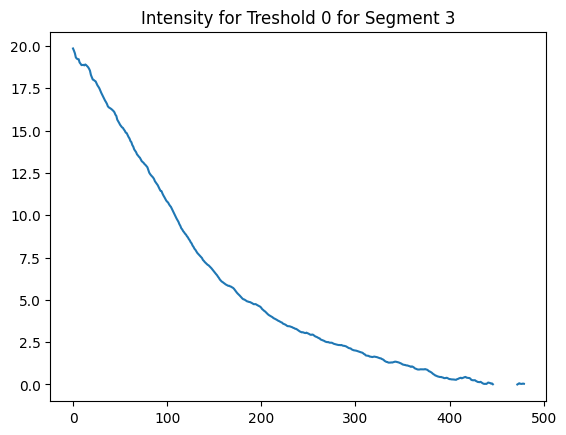

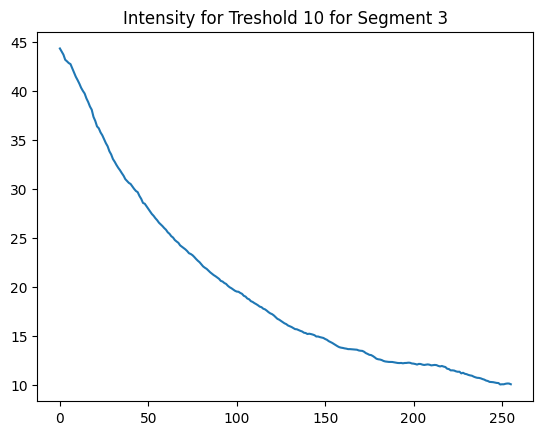

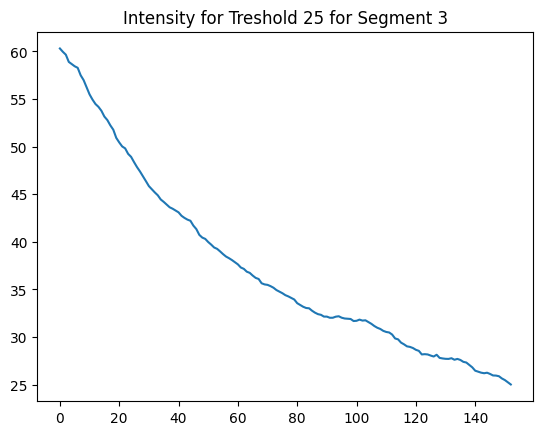

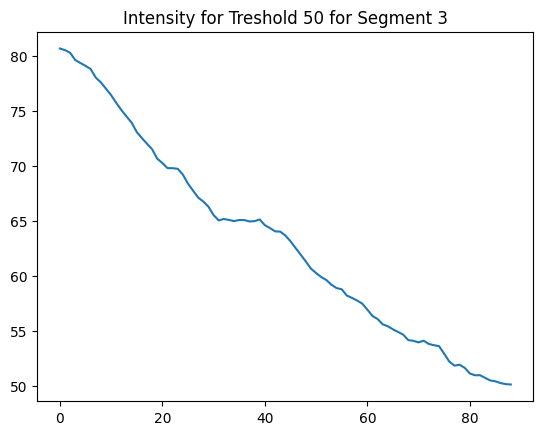

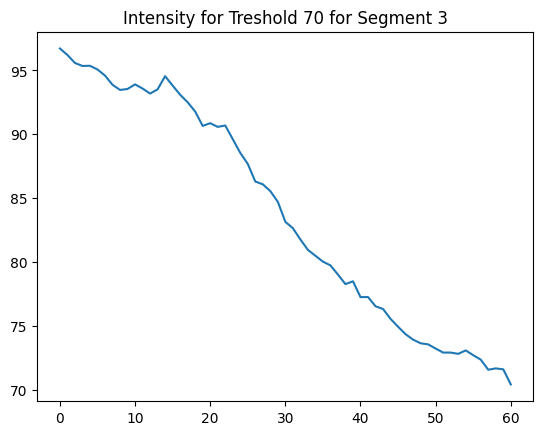

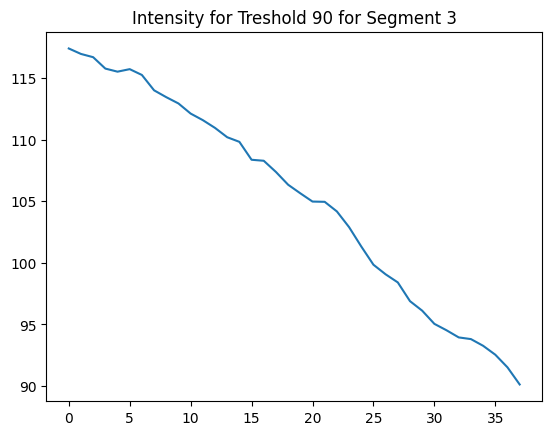

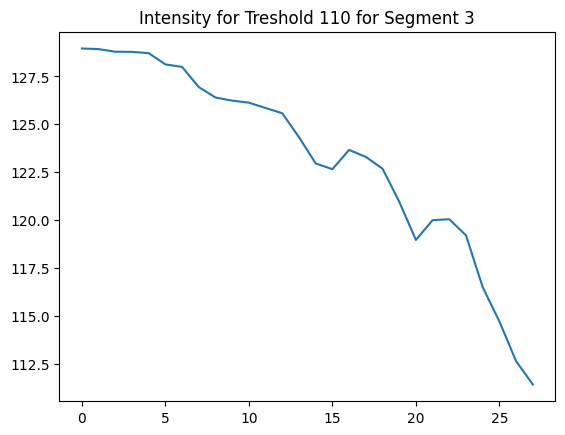

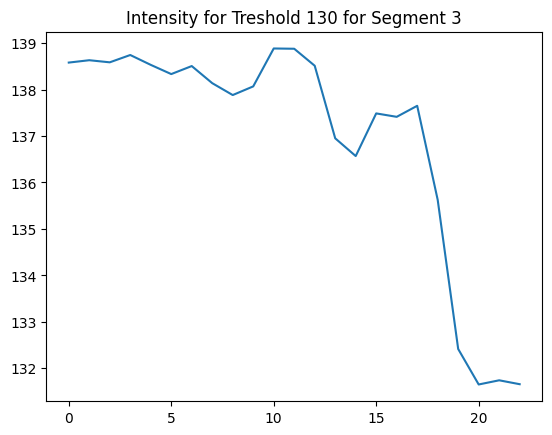

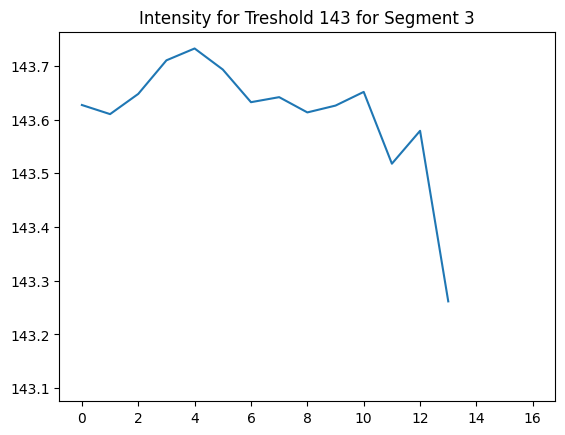

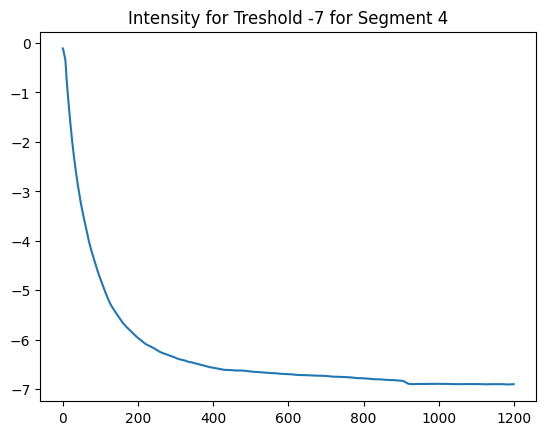

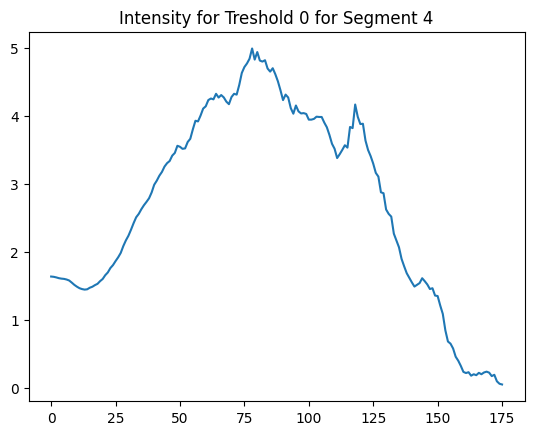

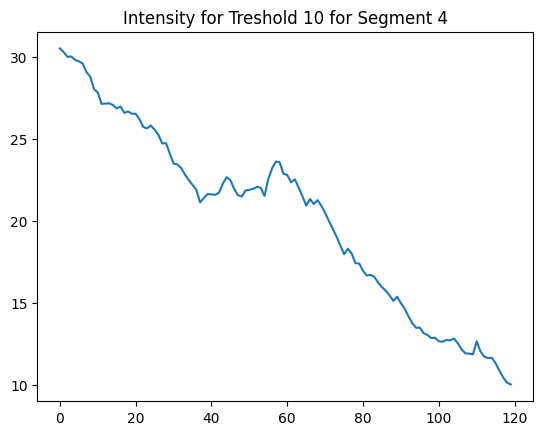

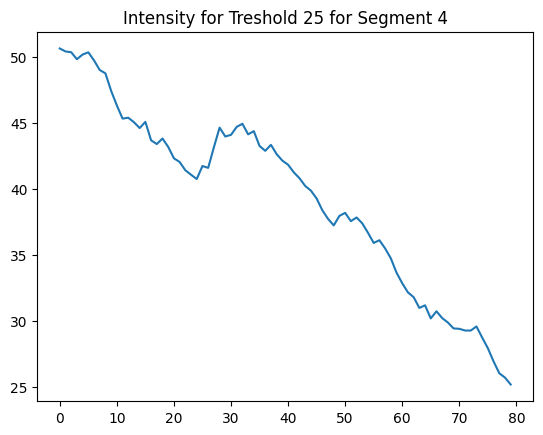

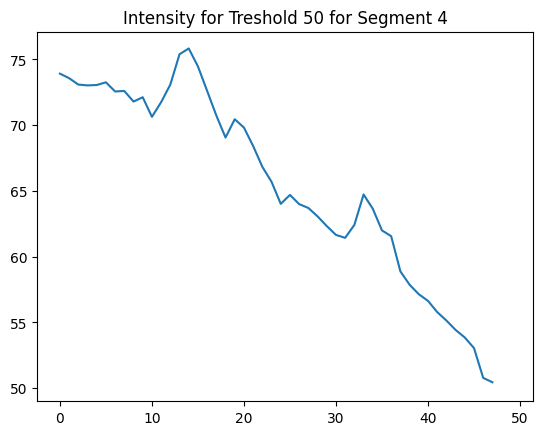

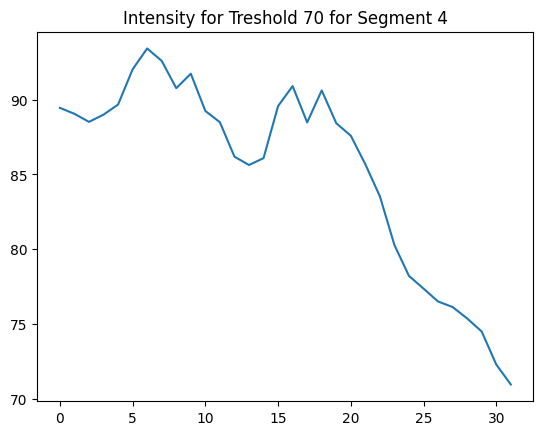

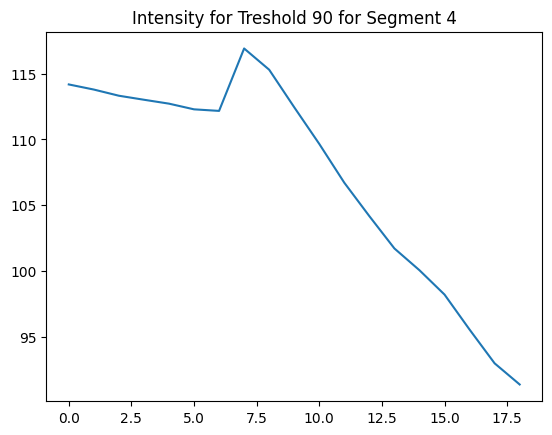

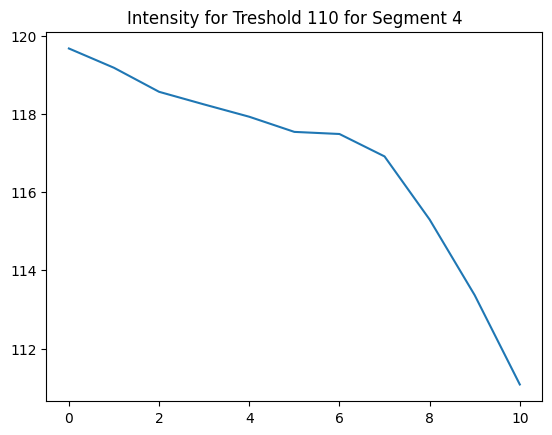

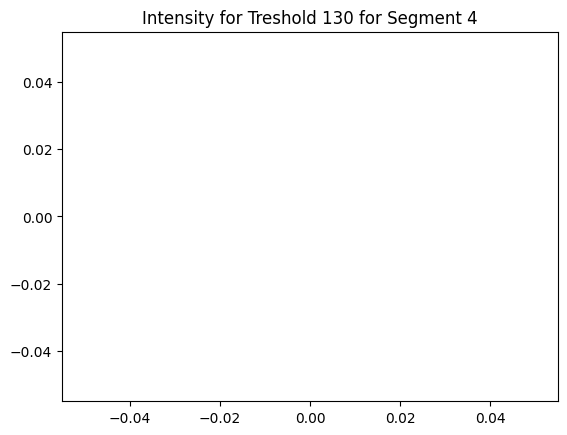

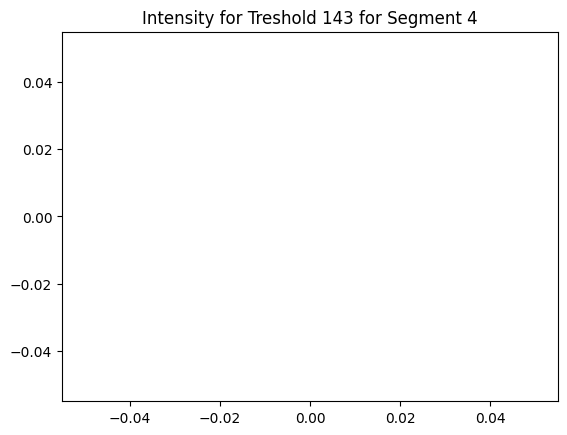

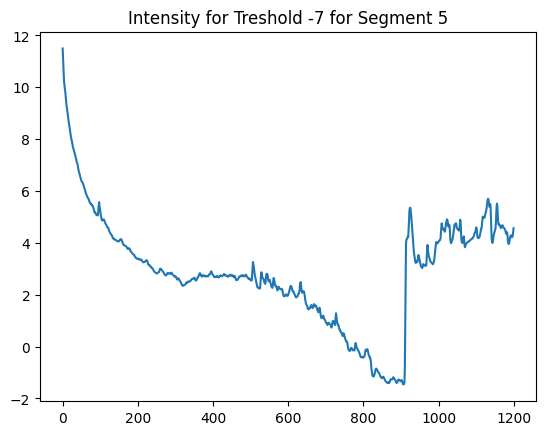

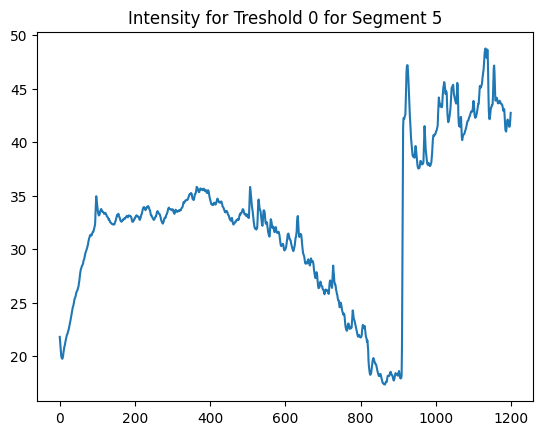

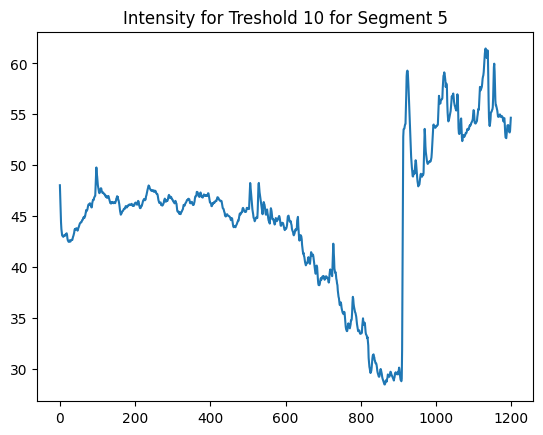

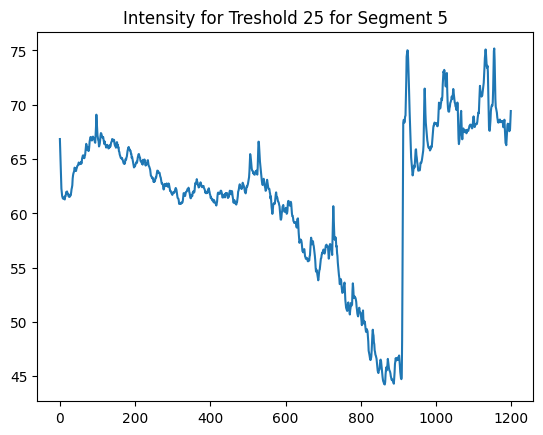

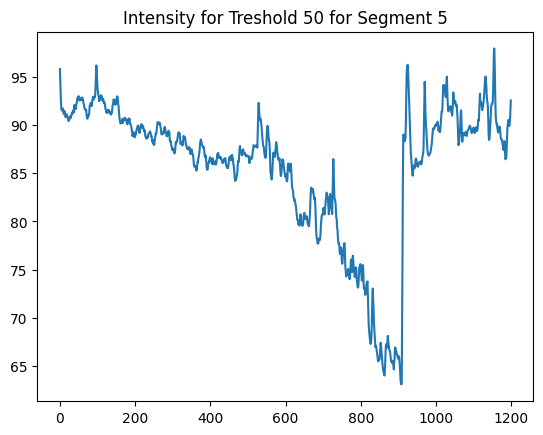

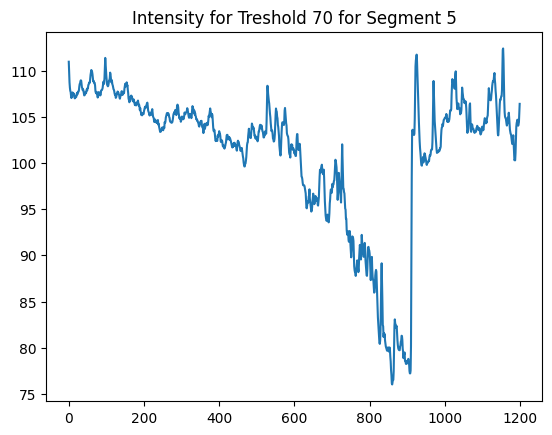

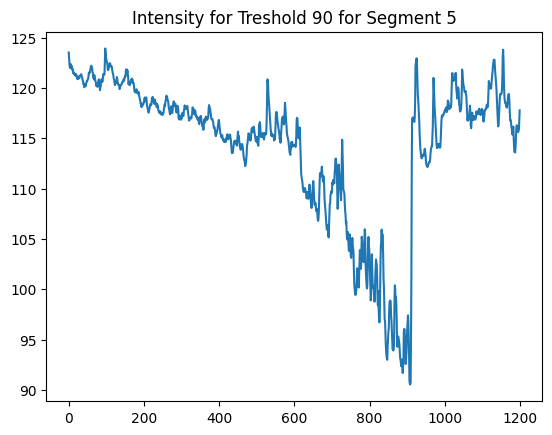

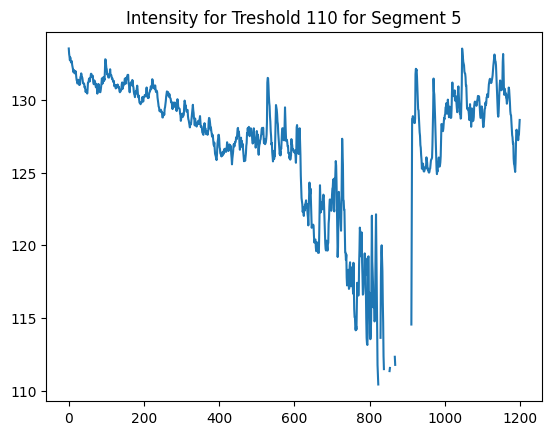

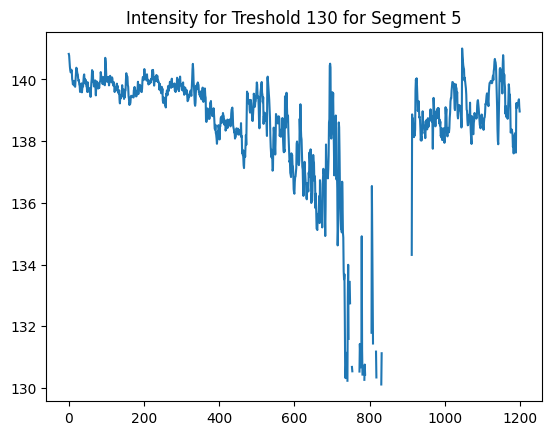

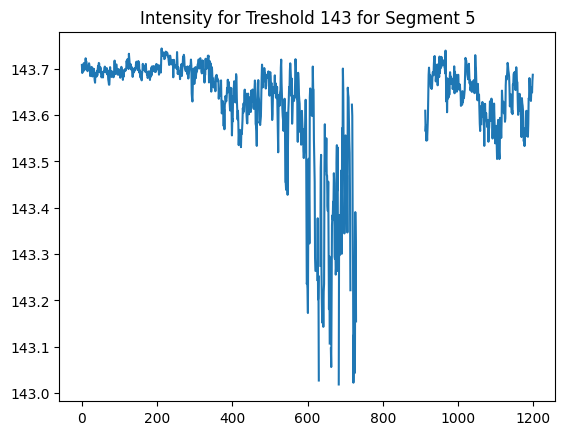

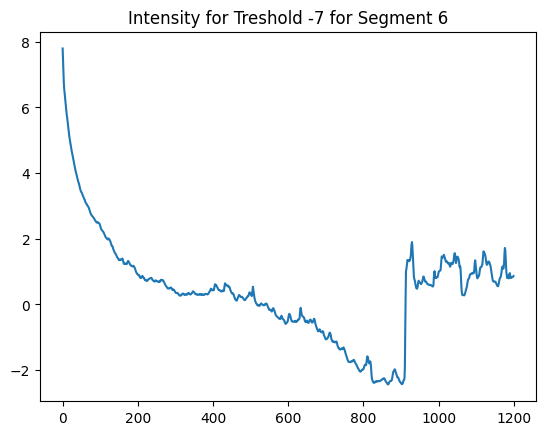

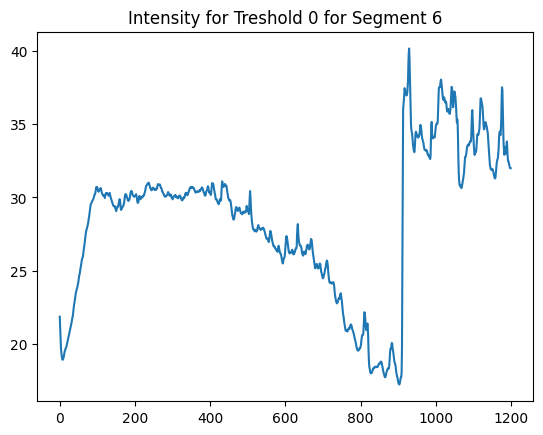

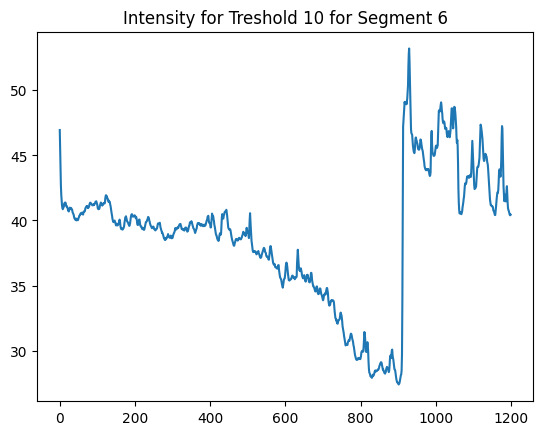

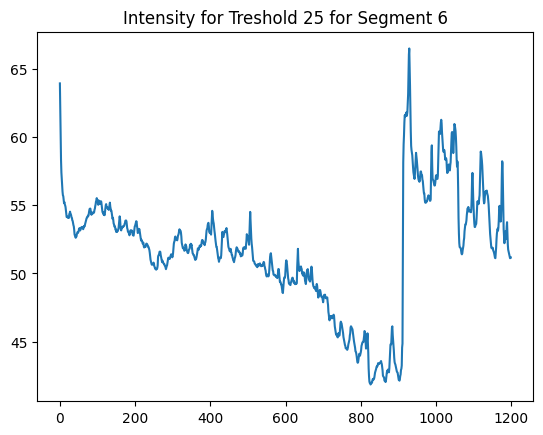

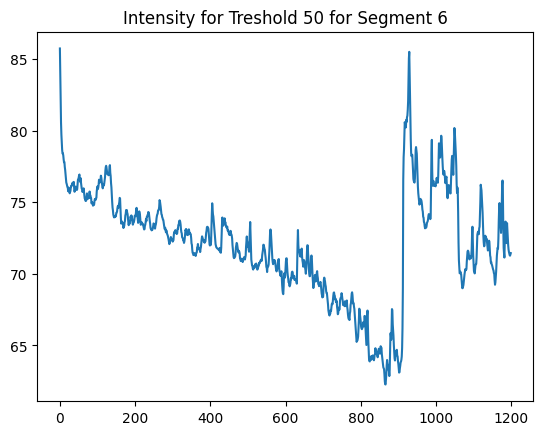

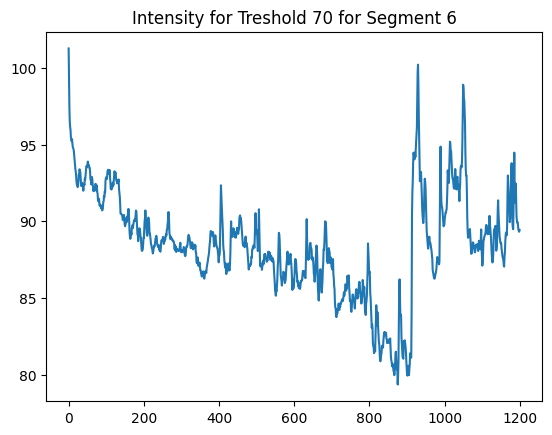

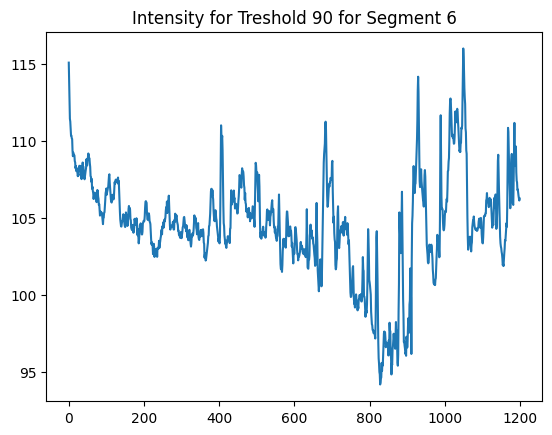

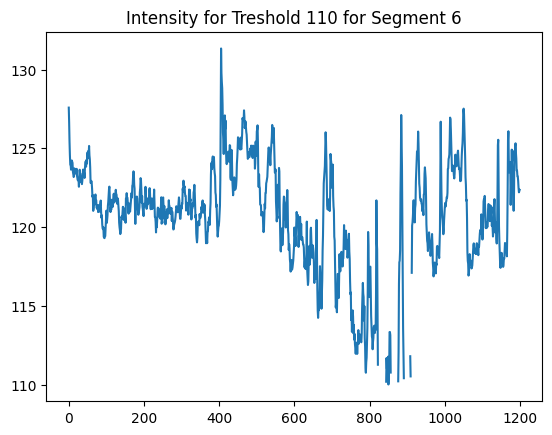

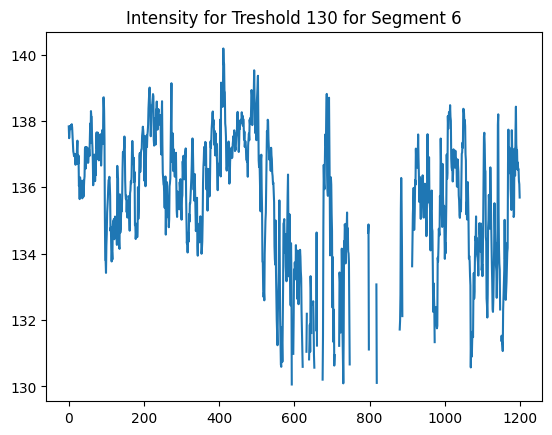

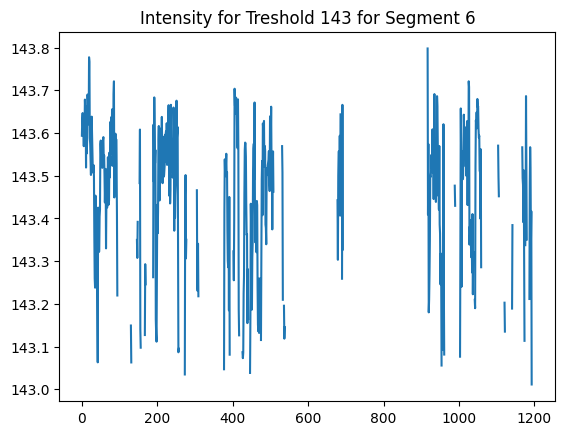

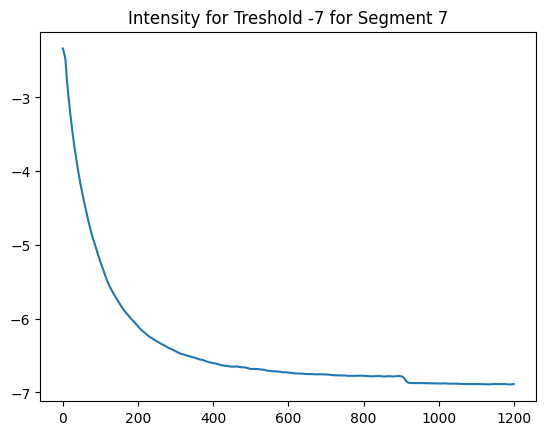

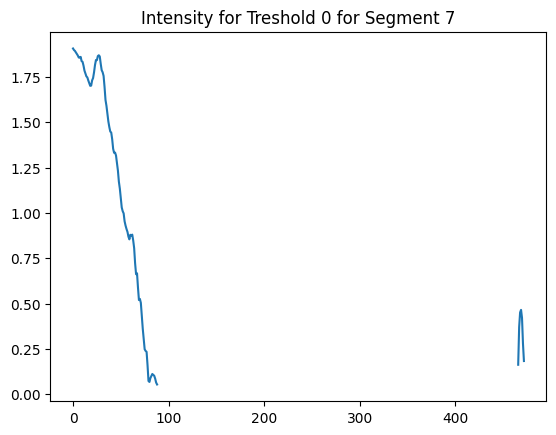

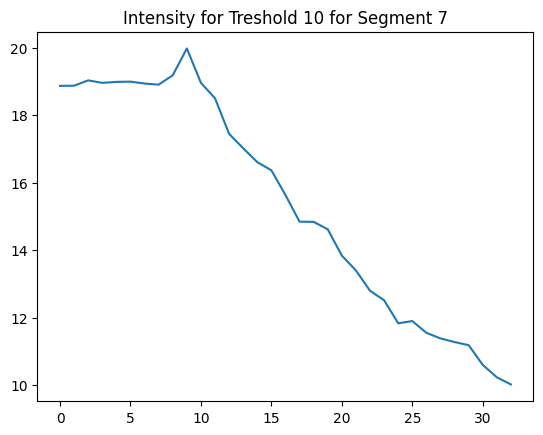

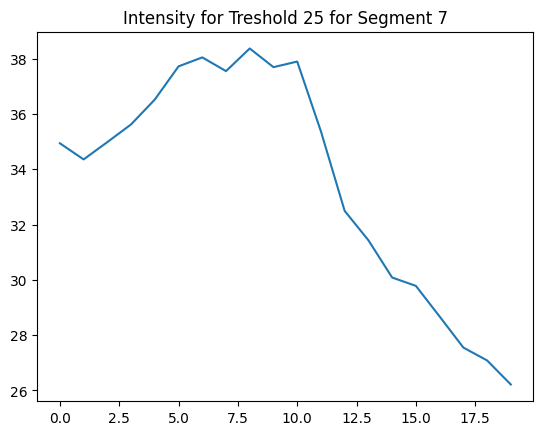

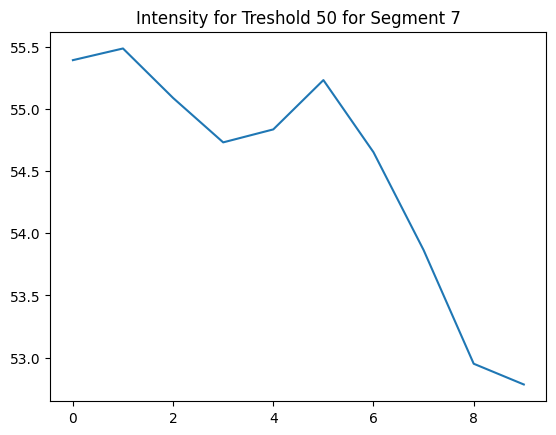

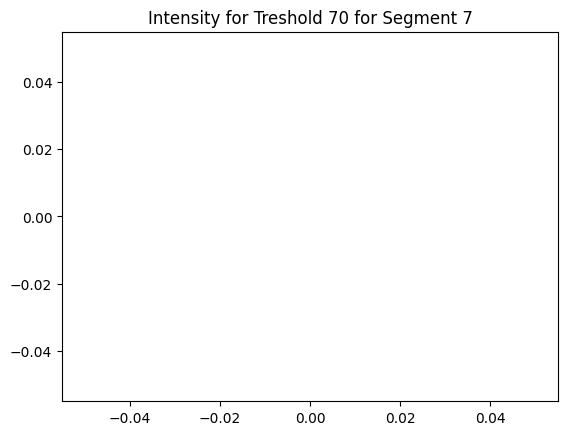

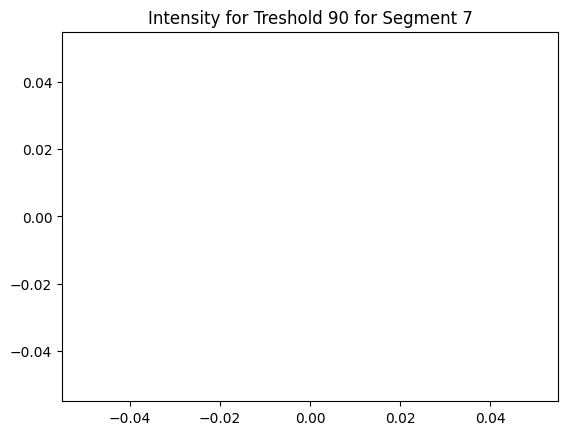

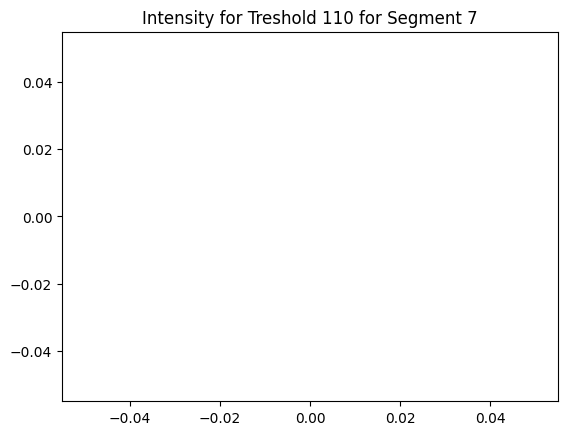

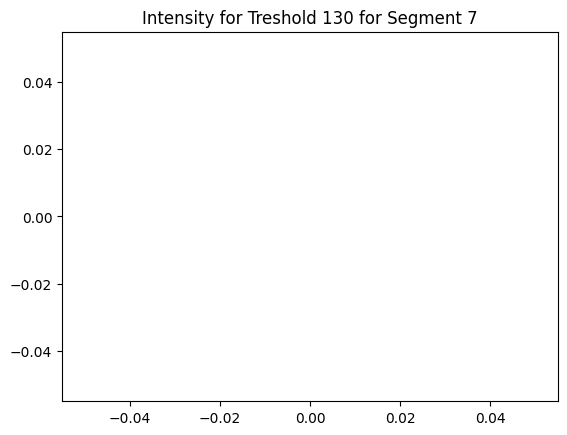

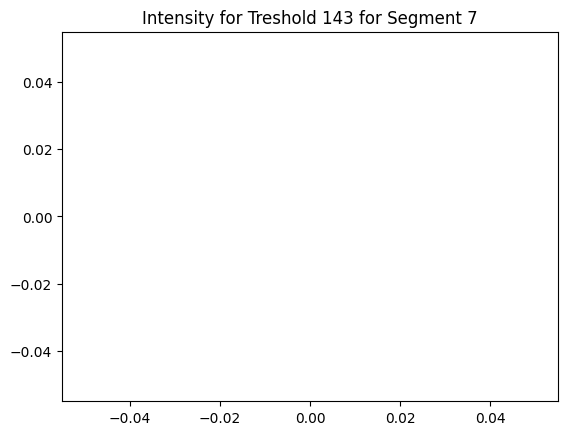

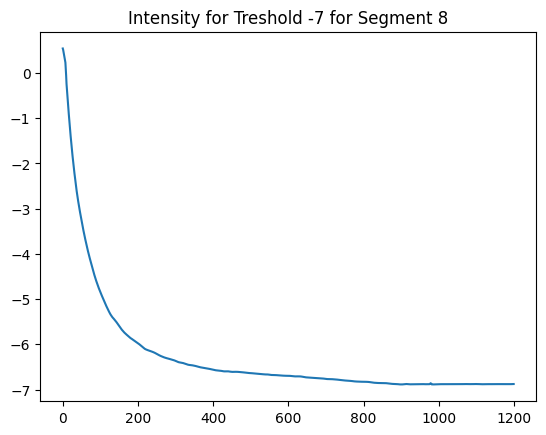

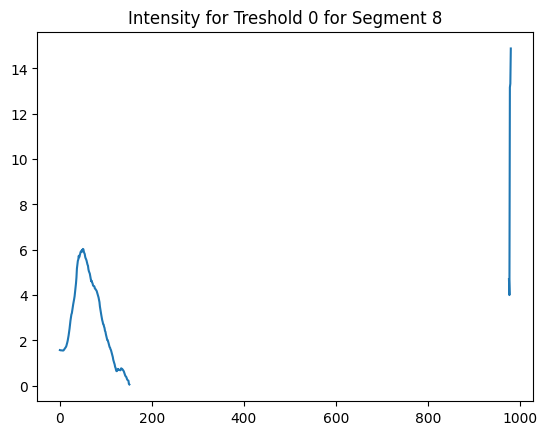

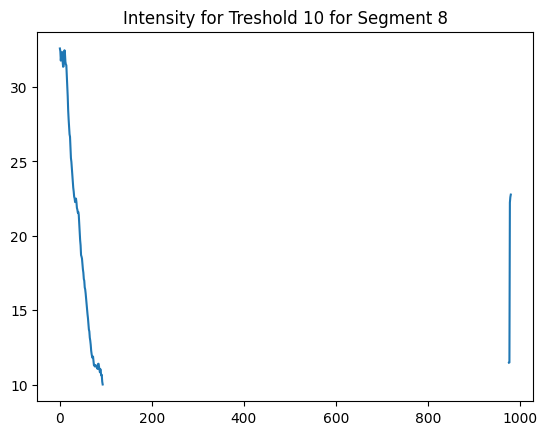

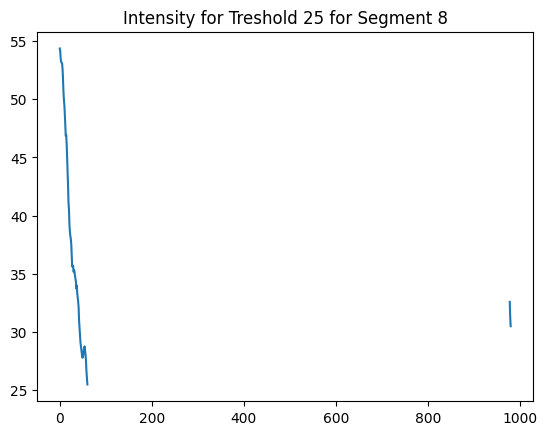

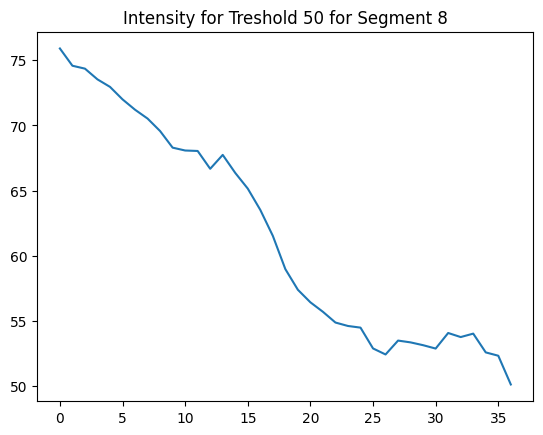

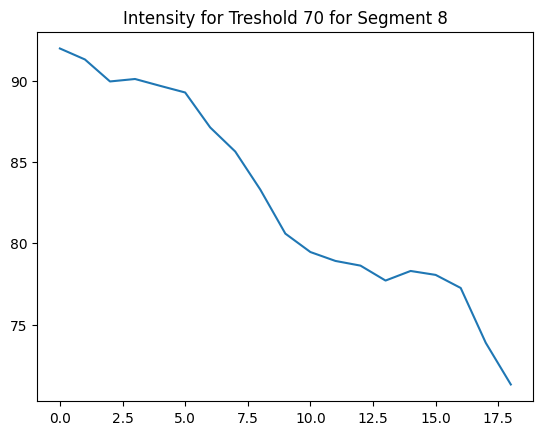

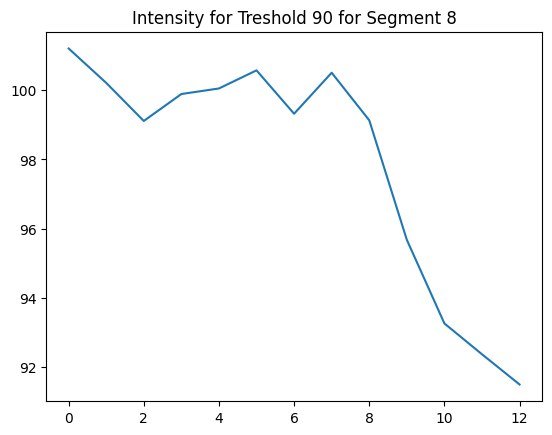

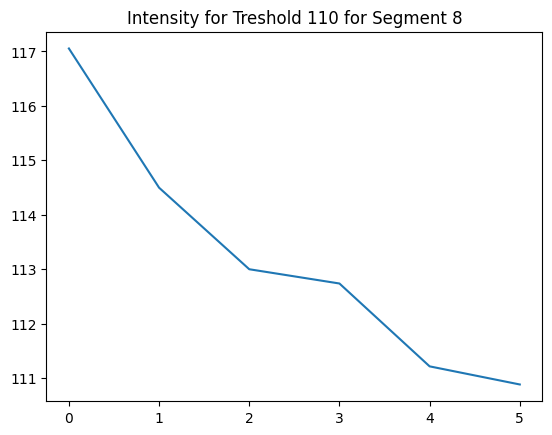

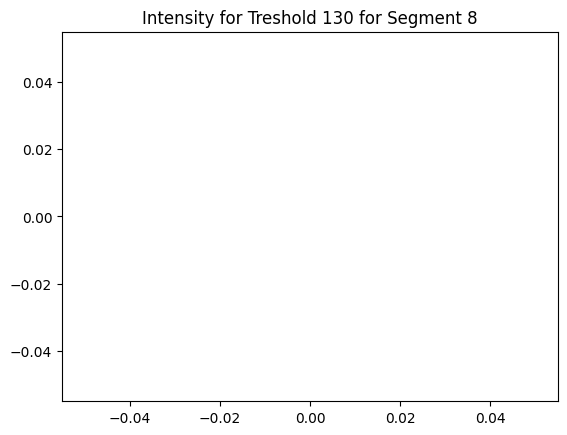

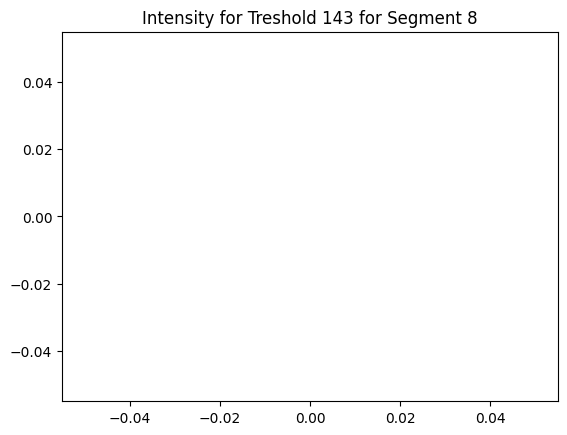

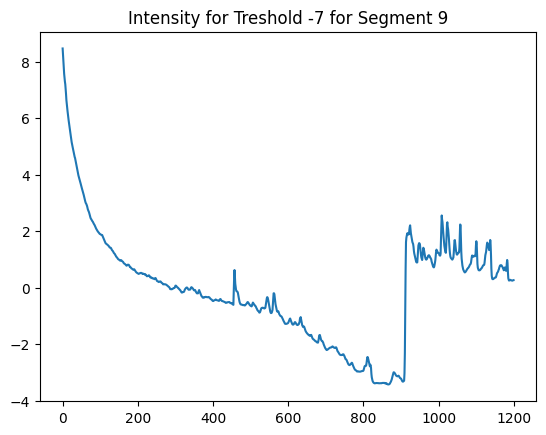

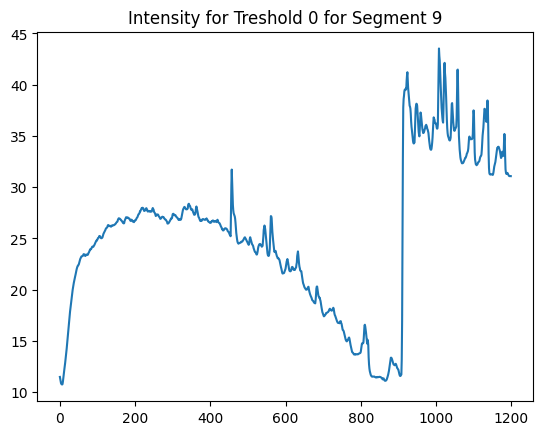

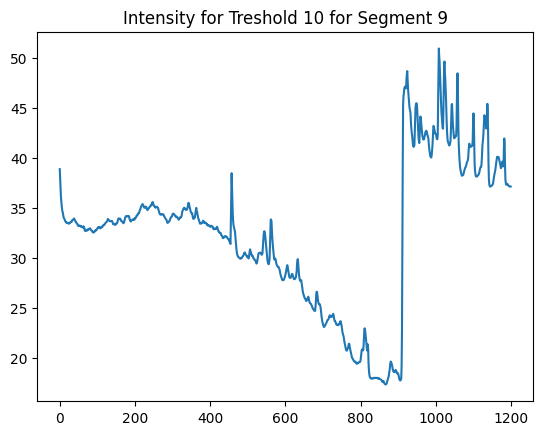

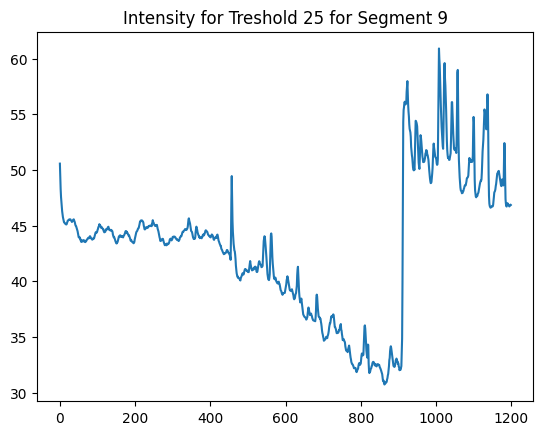

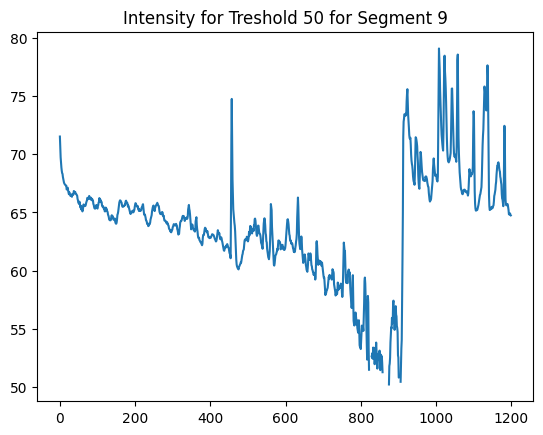

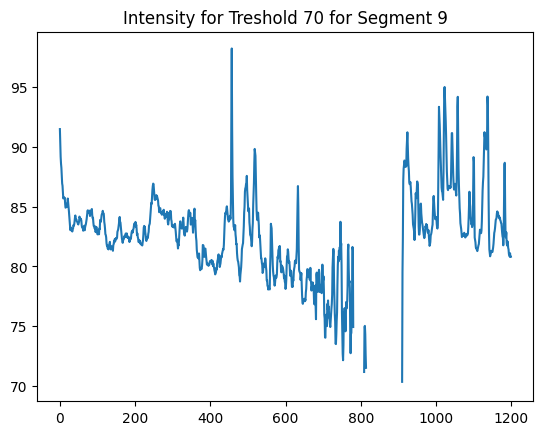

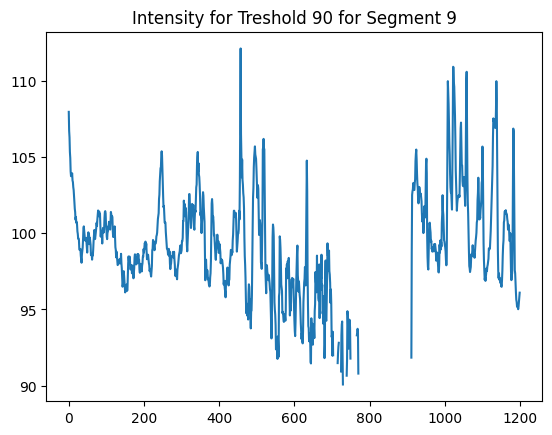

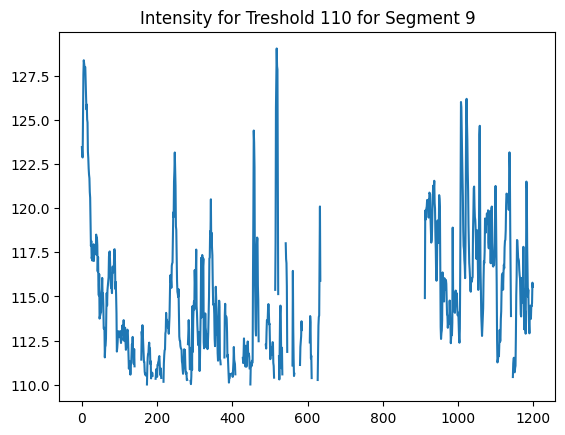

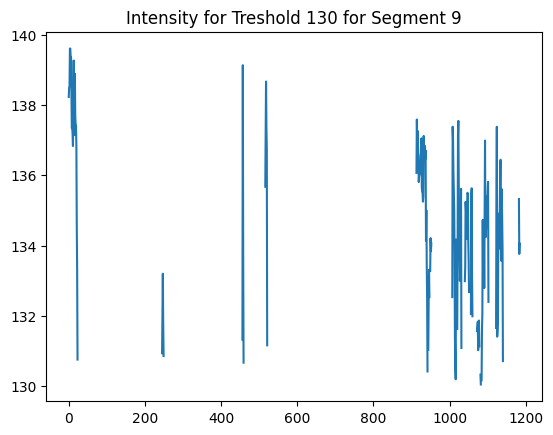

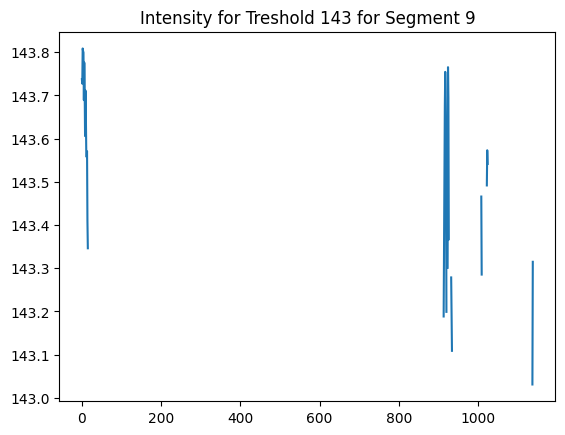

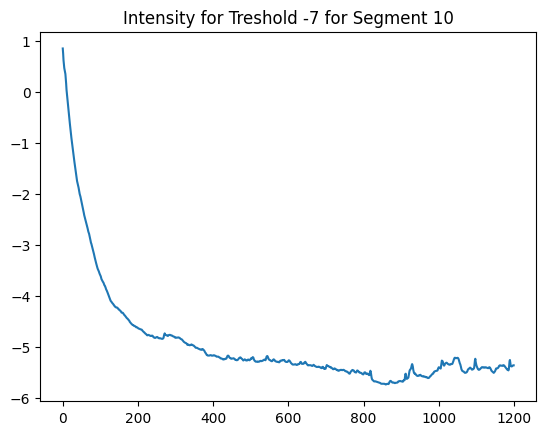

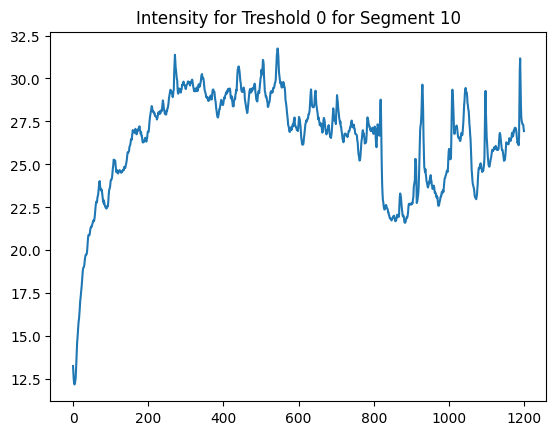

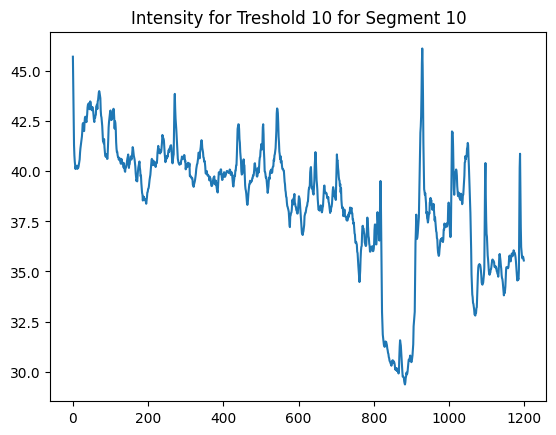

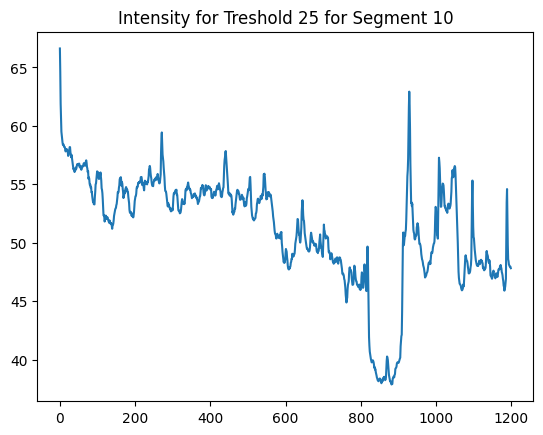

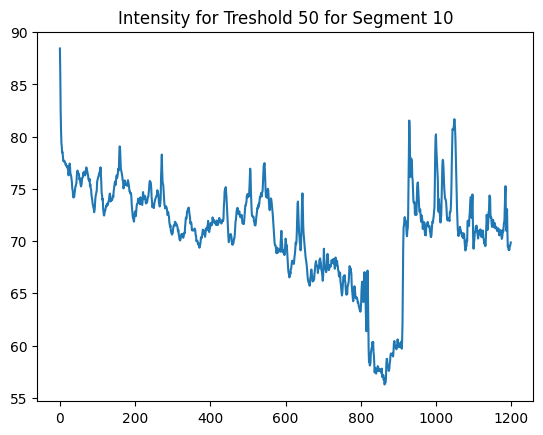

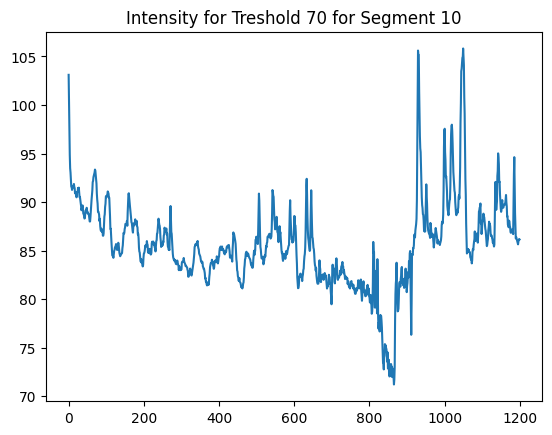

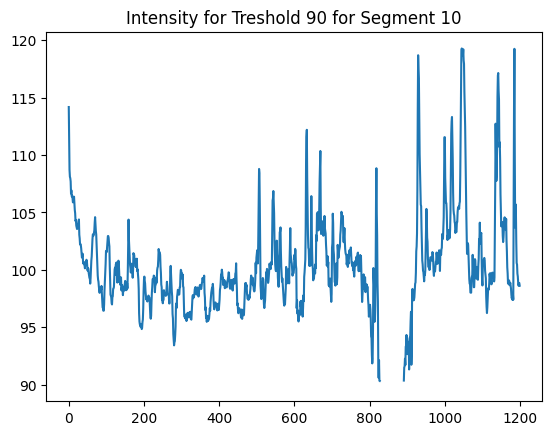

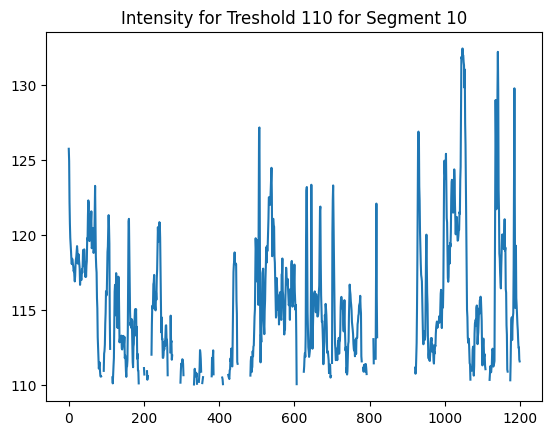

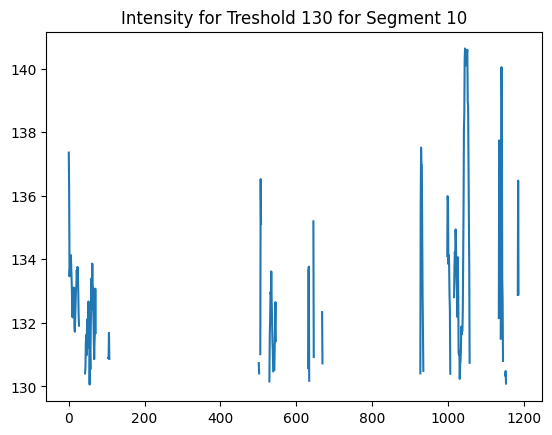

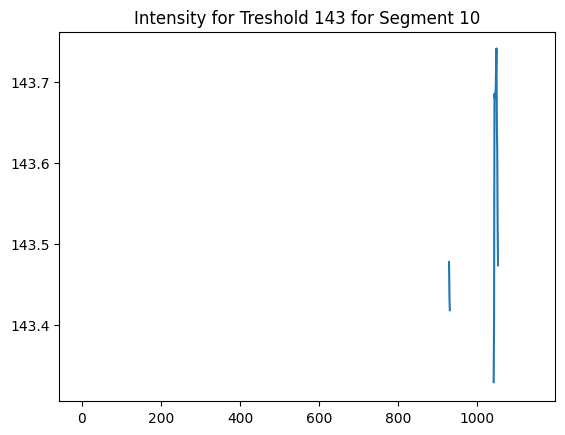

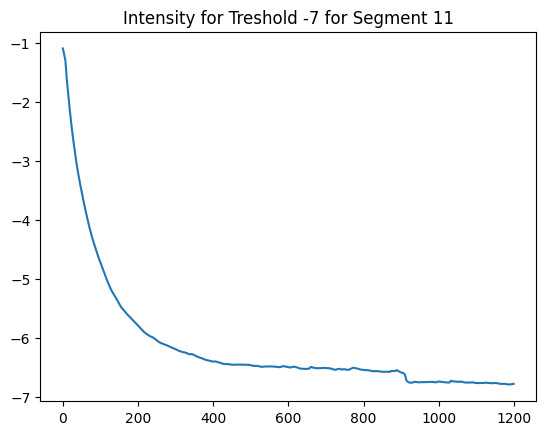

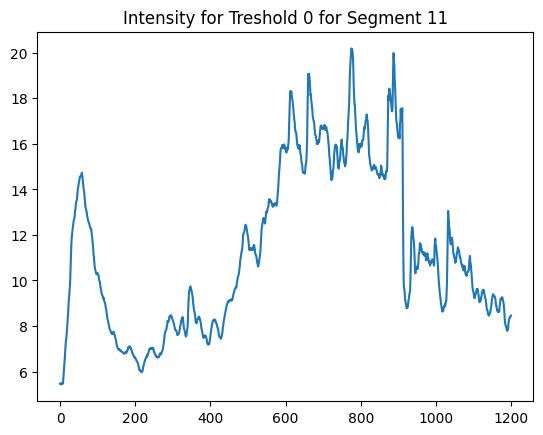

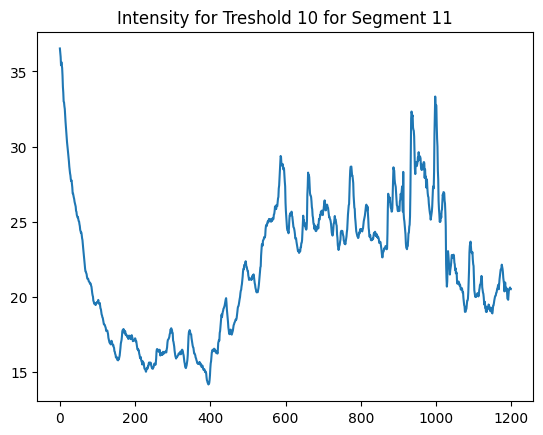

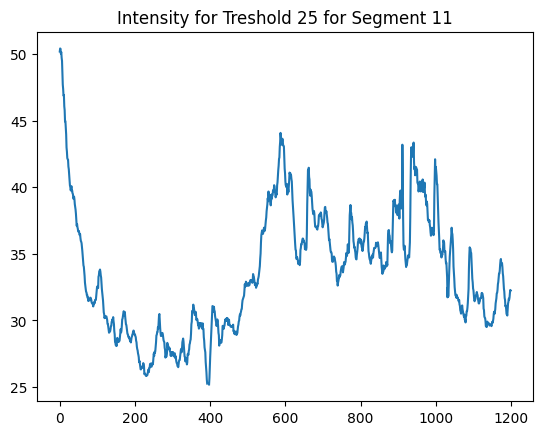

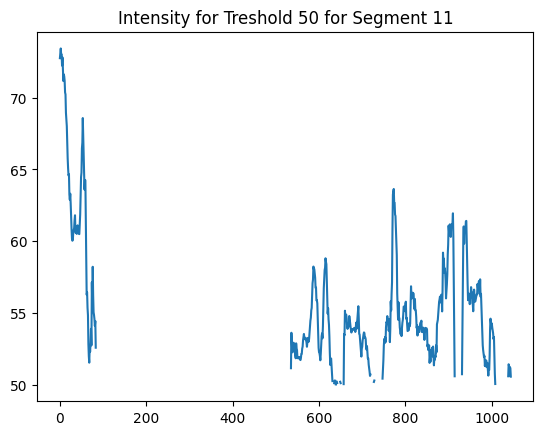

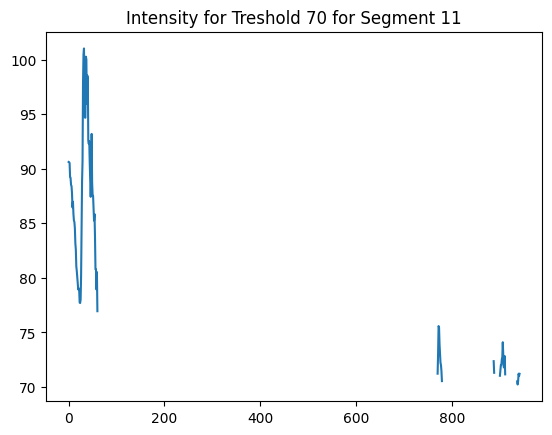

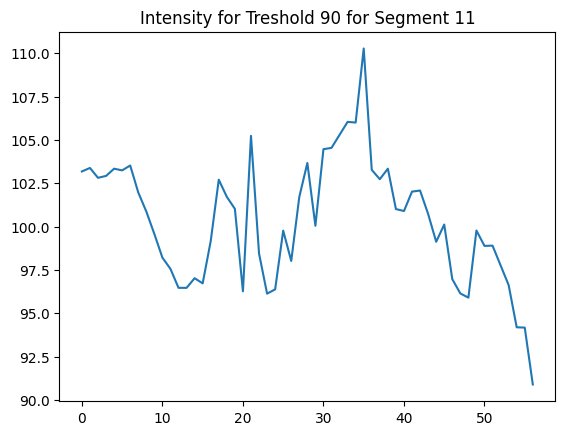

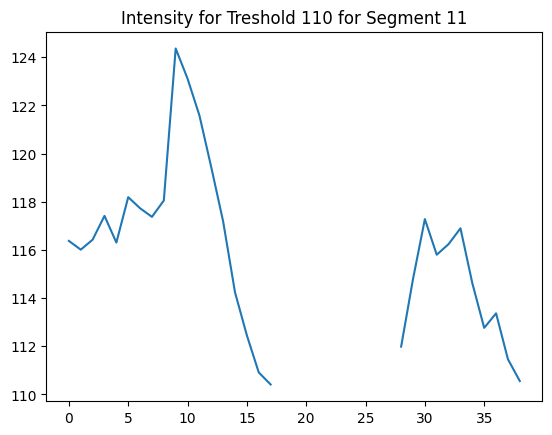

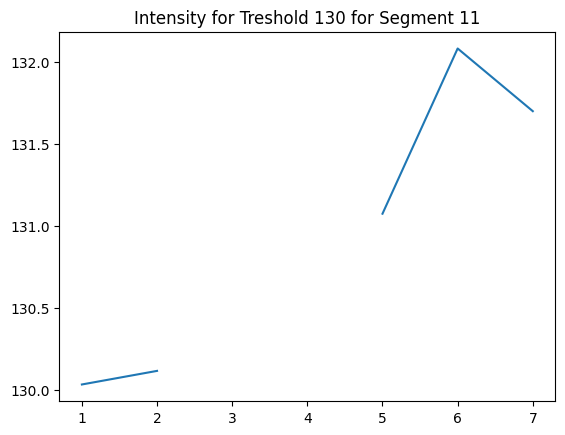

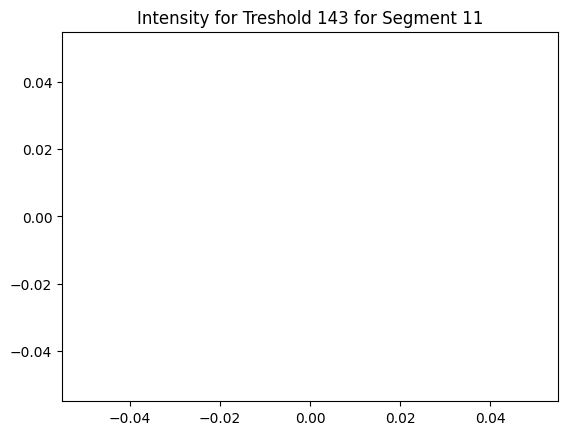

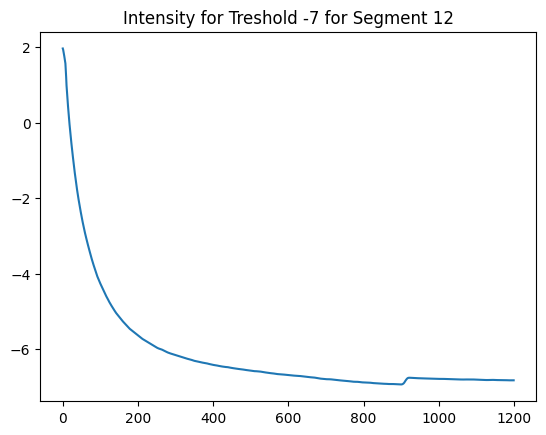

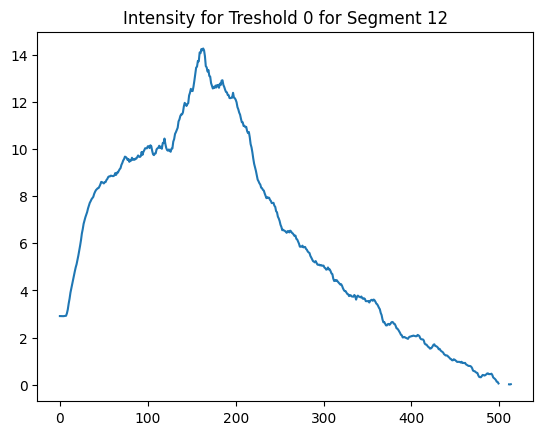

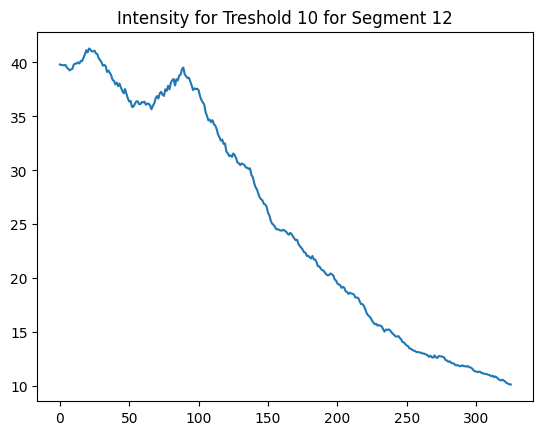

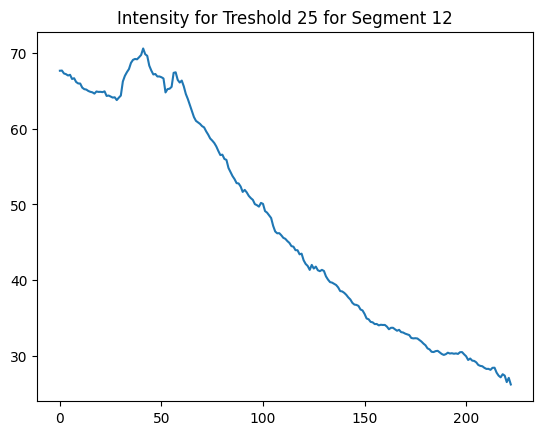

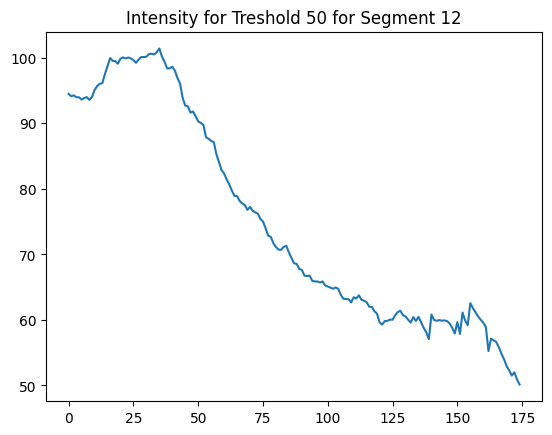

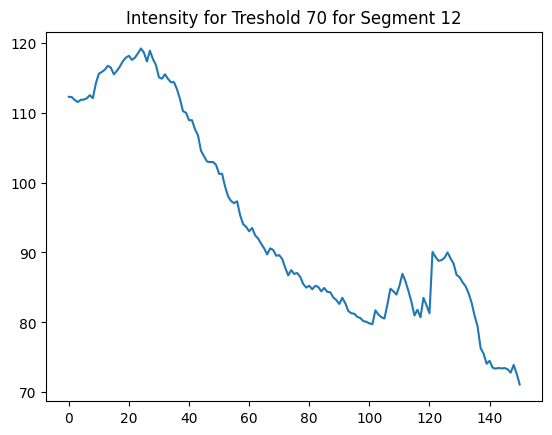

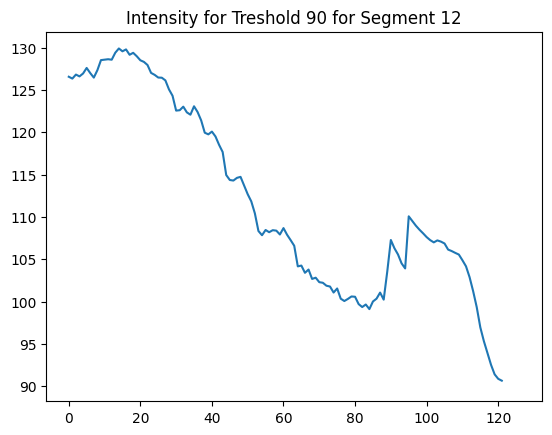

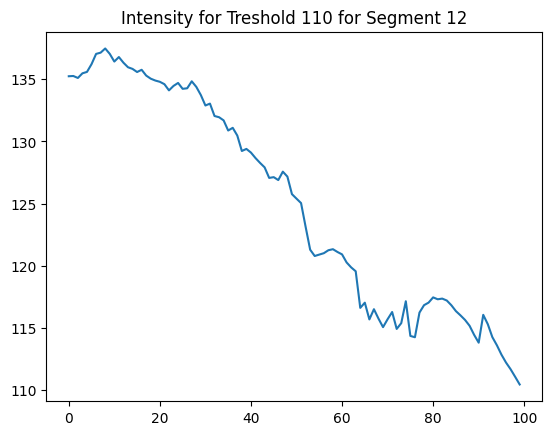

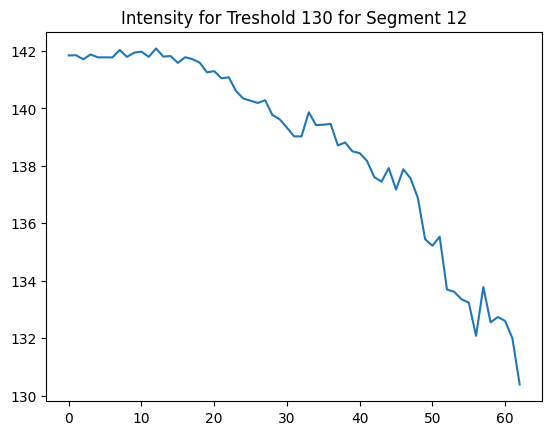

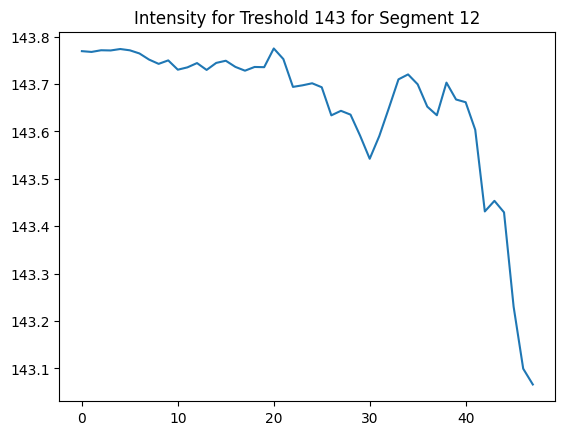

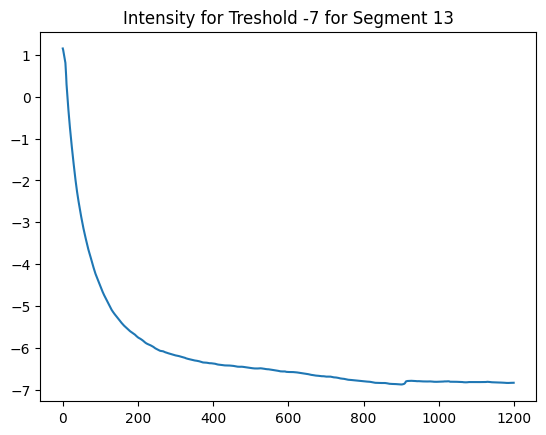

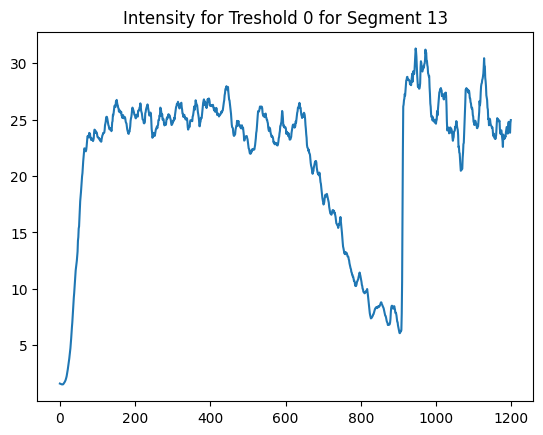

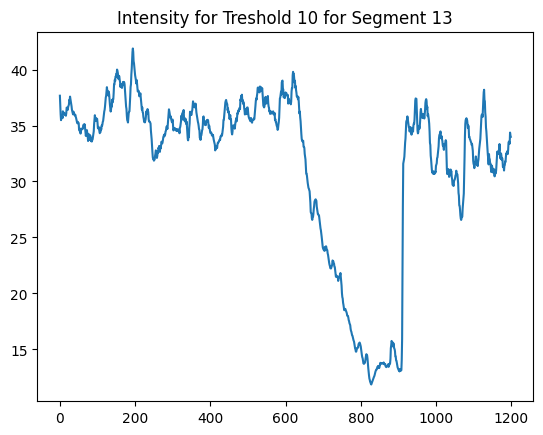

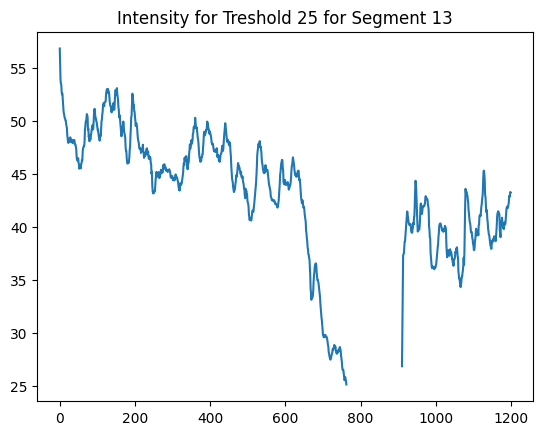

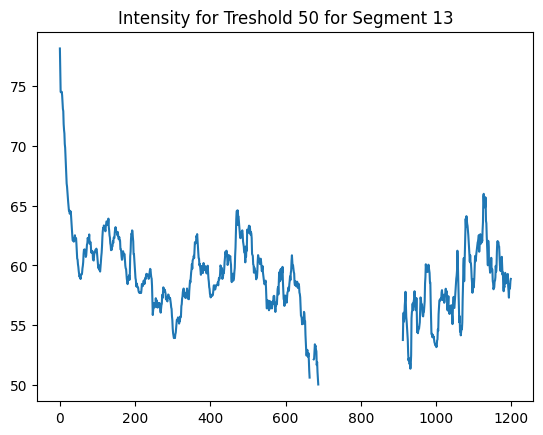

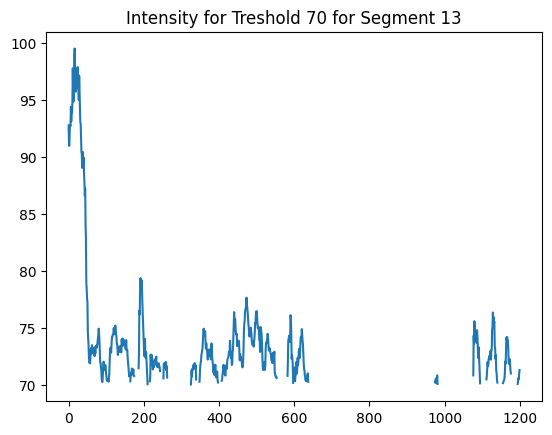

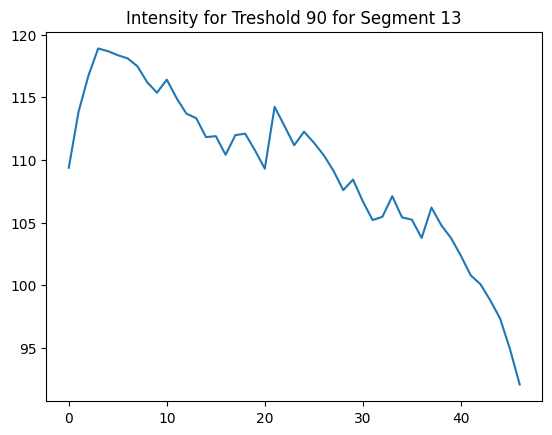

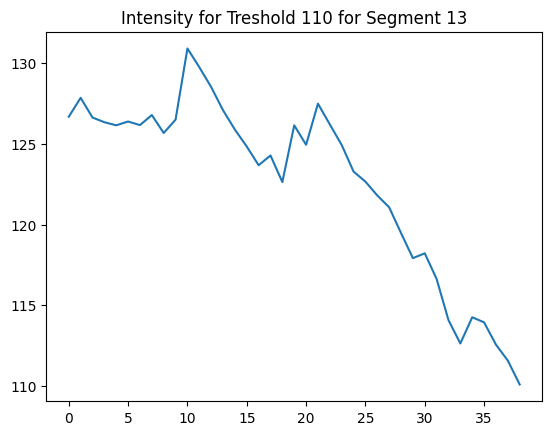

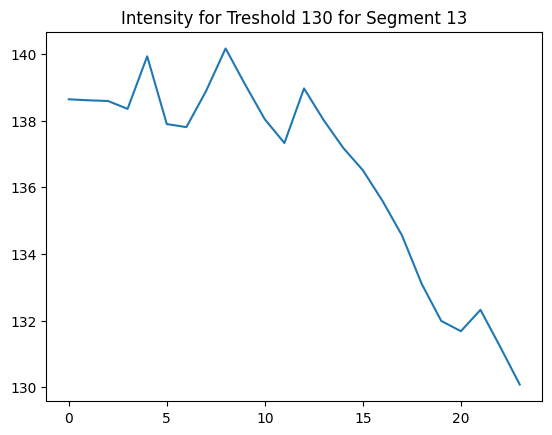

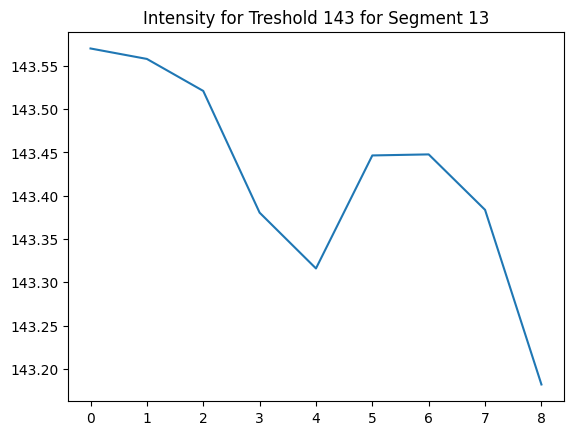

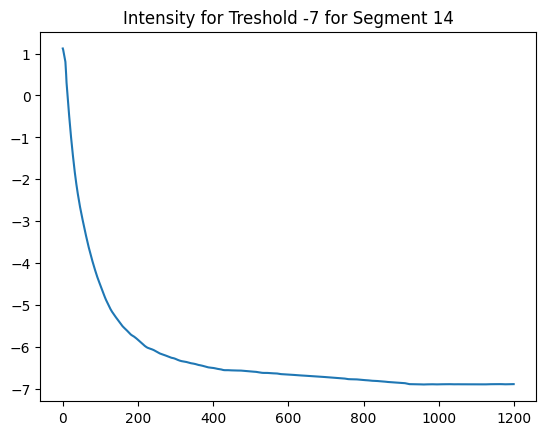

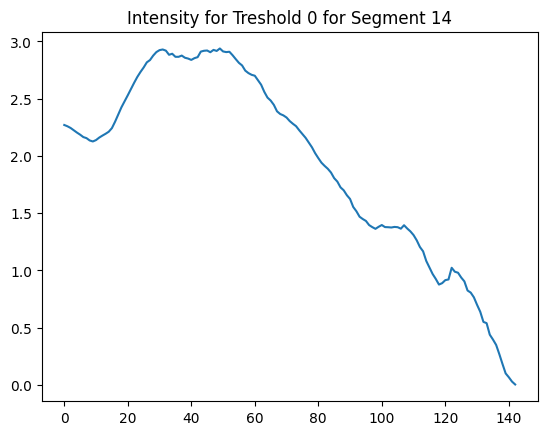

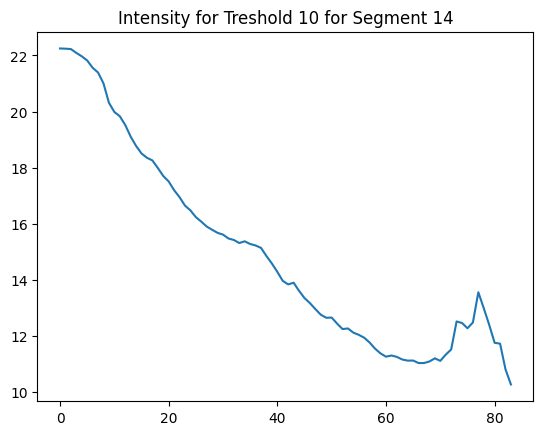

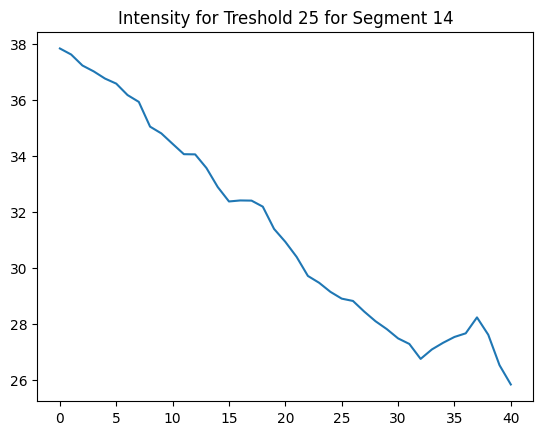

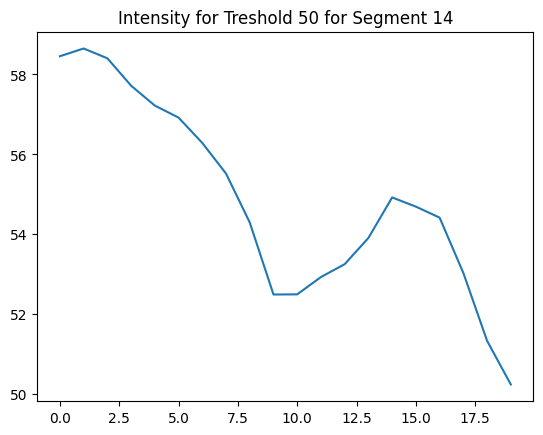

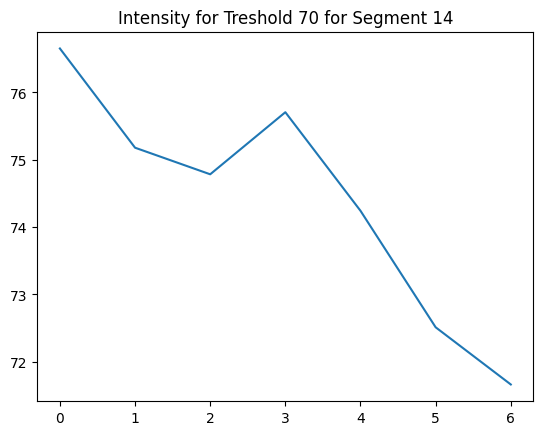

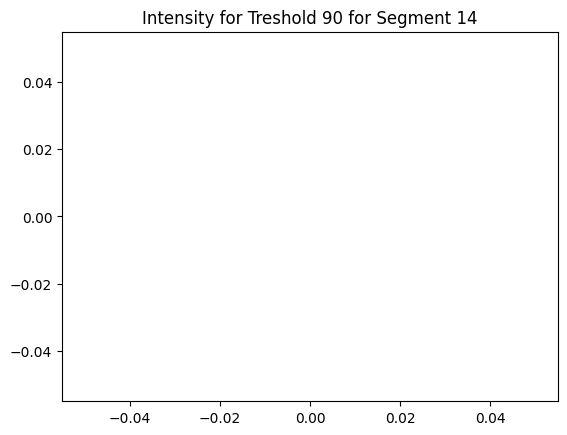

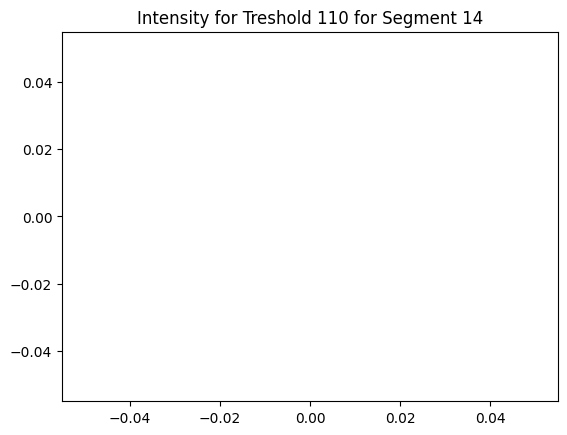

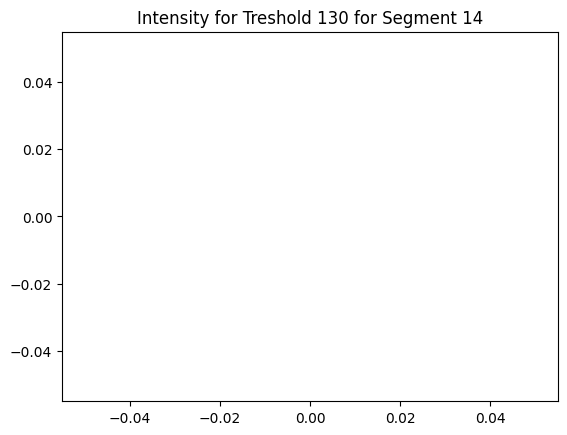

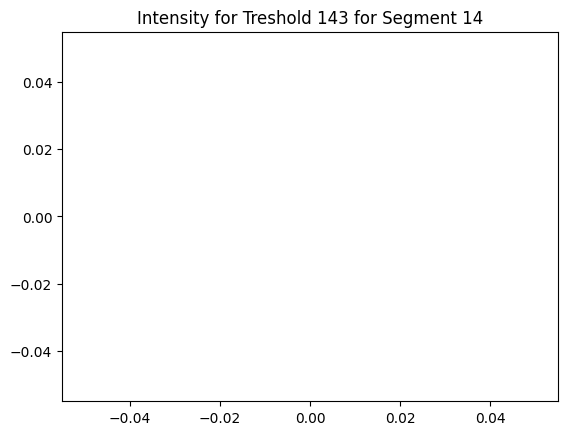

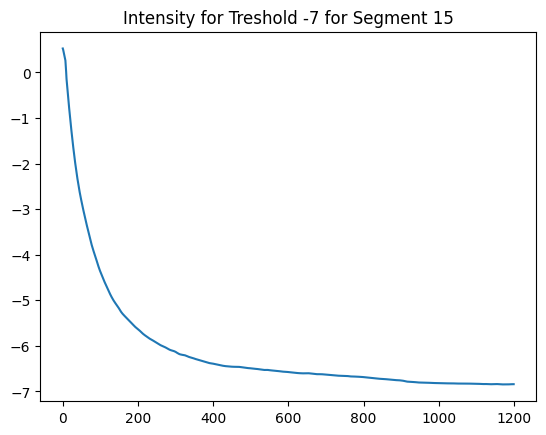

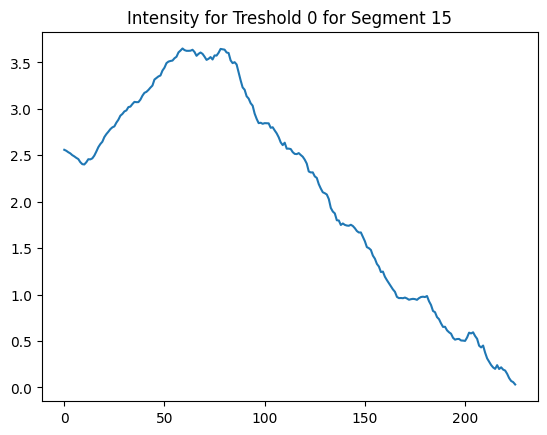

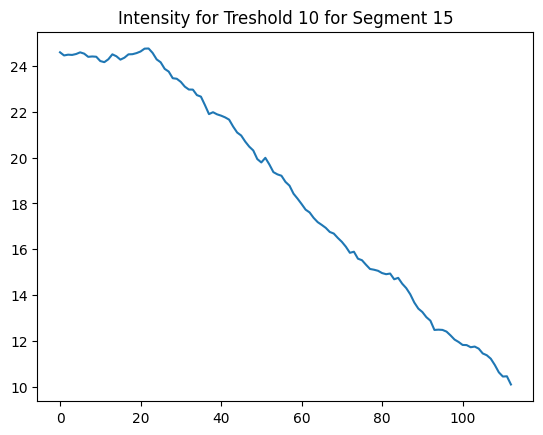

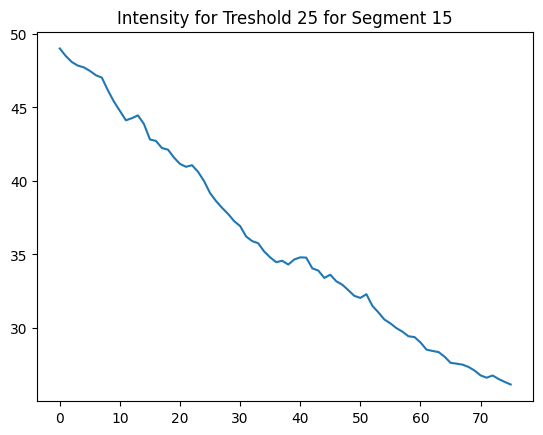

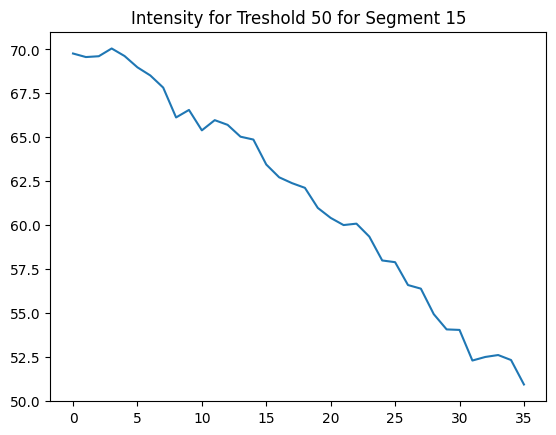

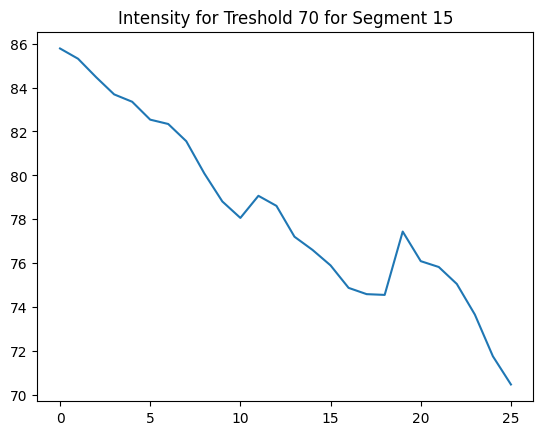

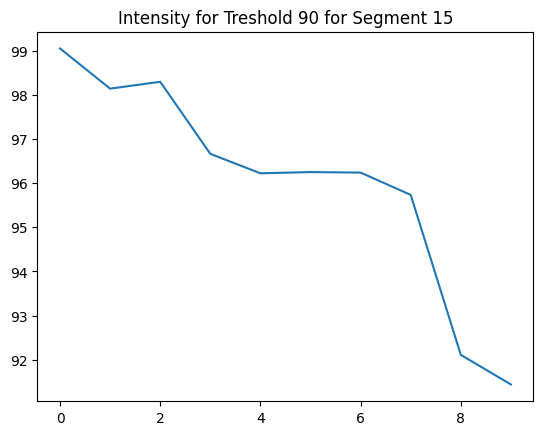

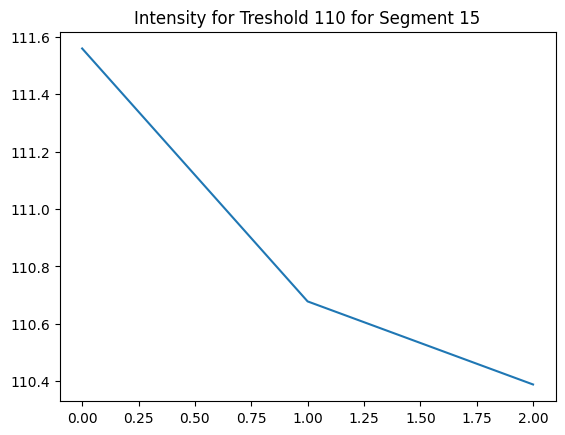

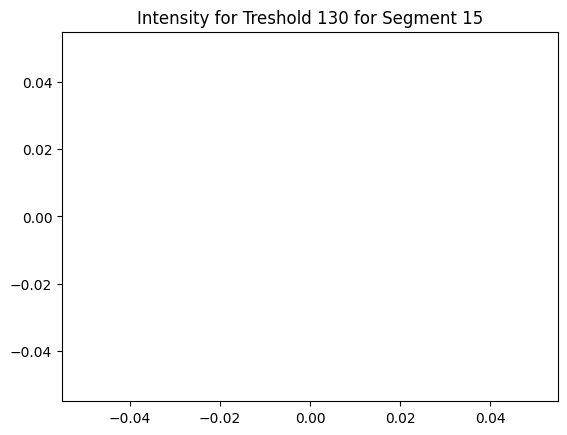

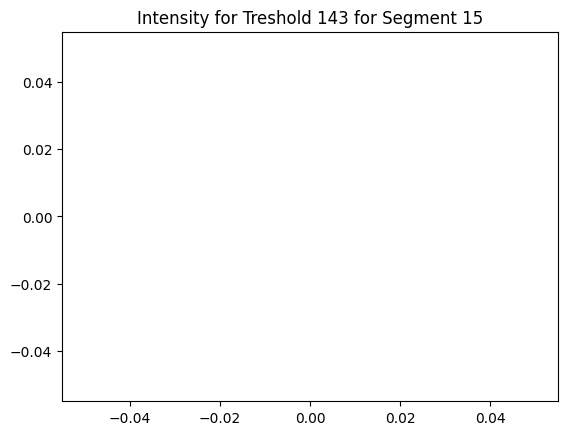

In [9]:
threshold = 50
print('struct min', struct.min())
print('struct max', struct.max())
fig1 = intensity_distribution(struct)[0]
time_series = intensity_mean(struct)
fig2 = intensity_per_frame(time_series)
first_frame = struct[:, :, 0]
plt.imshow(first_frame)
plt.title('Первый кадр')
plt.show()
segment_size = 256
thresholds = [-7, 0, 10, 25, 50, 70, 90, 110, 130, 143]
segments = segment_frame(struct, segment_size)
for segment in range(len(segments)):
    for threshold in thresholds:
        mean_intensity = intensity_mean(segments[segment], segment_size, threshold)
        plt.plot(mean_intensity)
        plt.title(f'Intensity for Treshold {threshold} for Segment {segment}')
        plt.savefig(f'Intensity for Treshold {threshold} for Segment {segment}')
        plt.show()

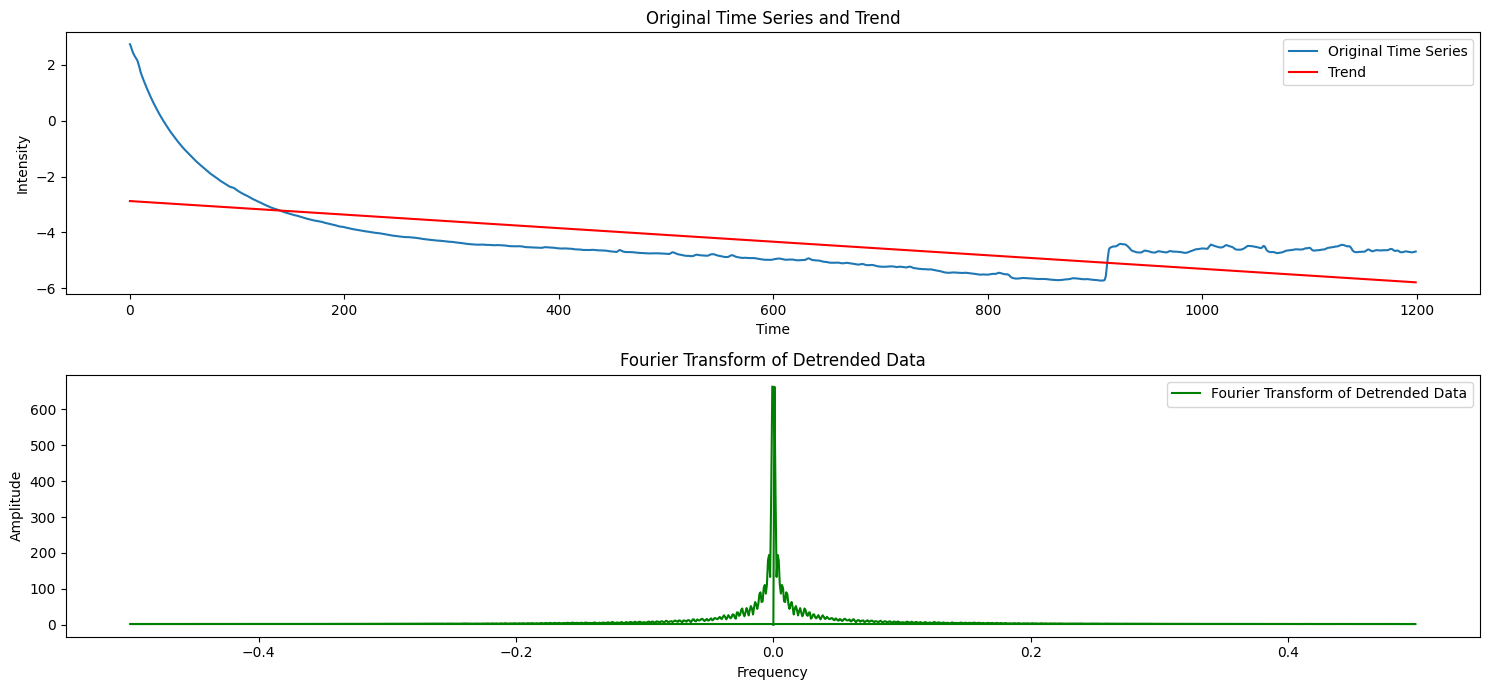

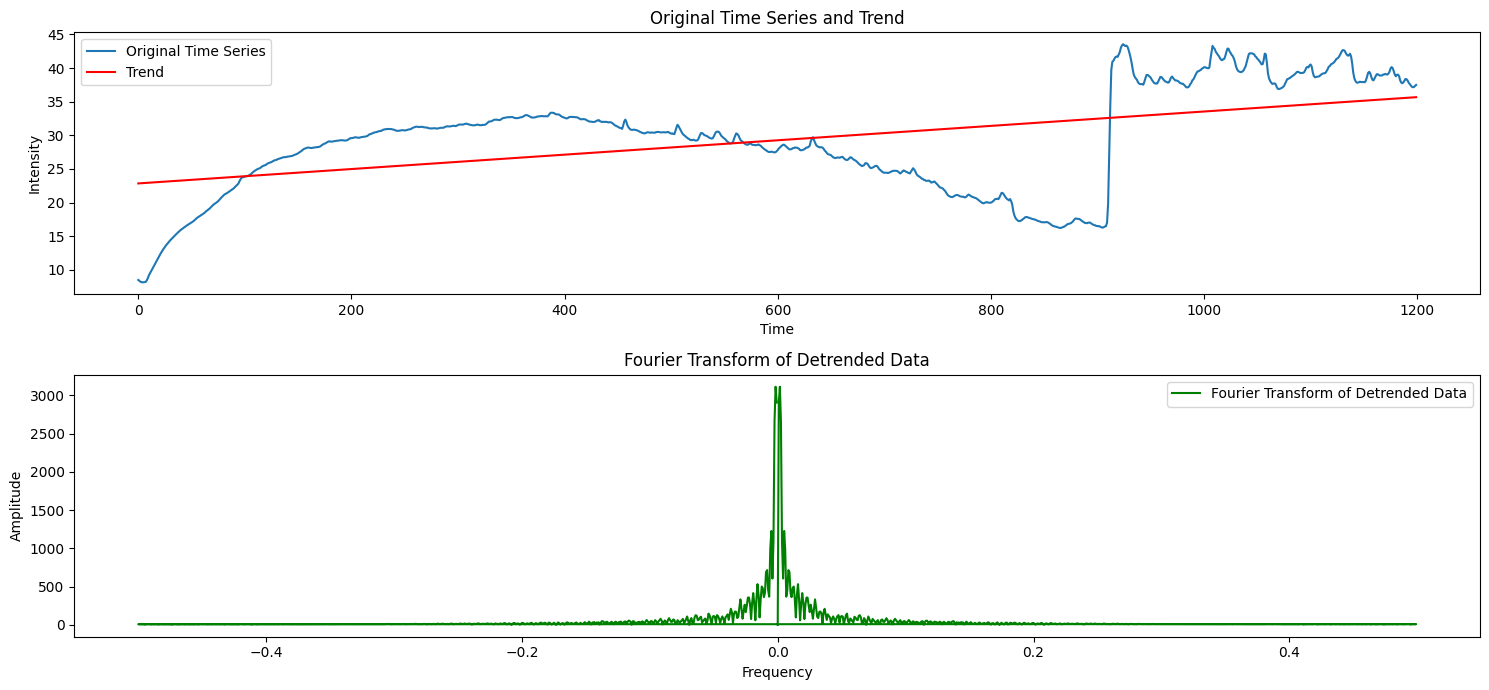

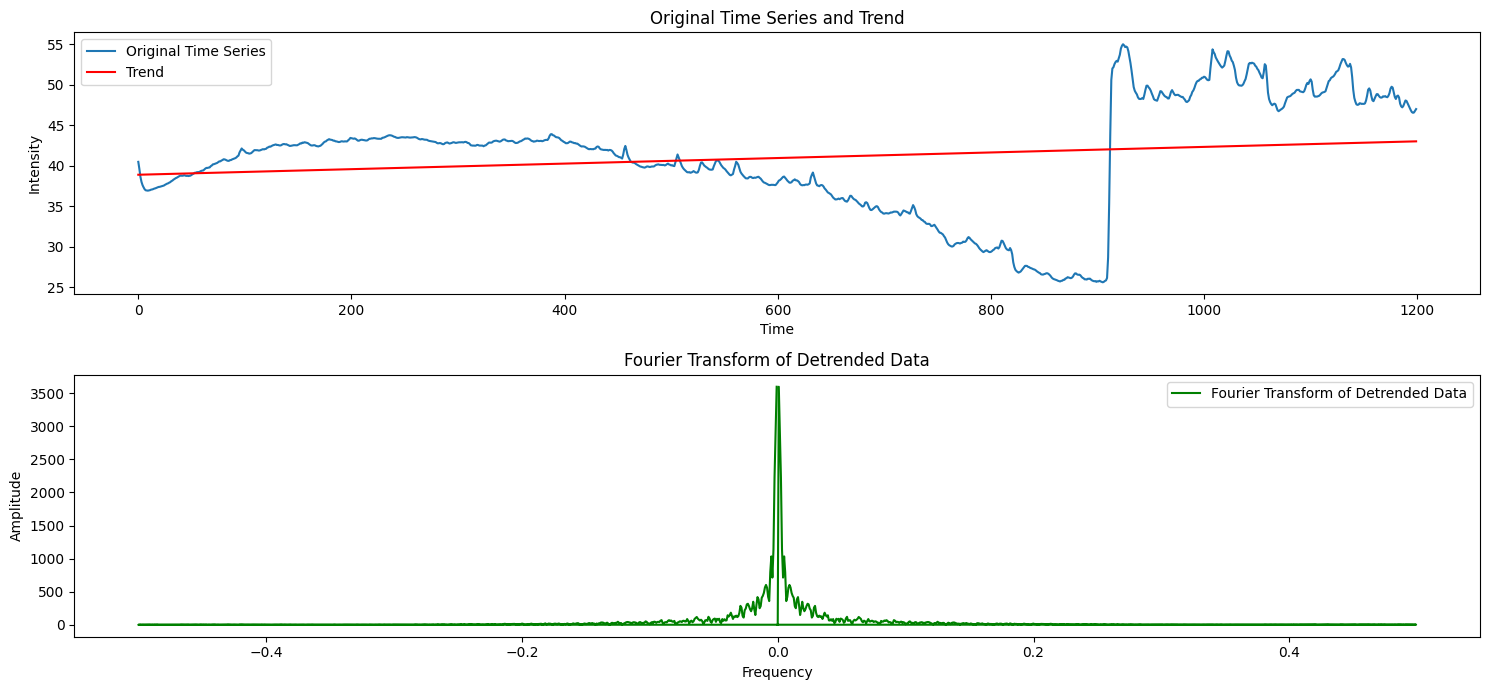

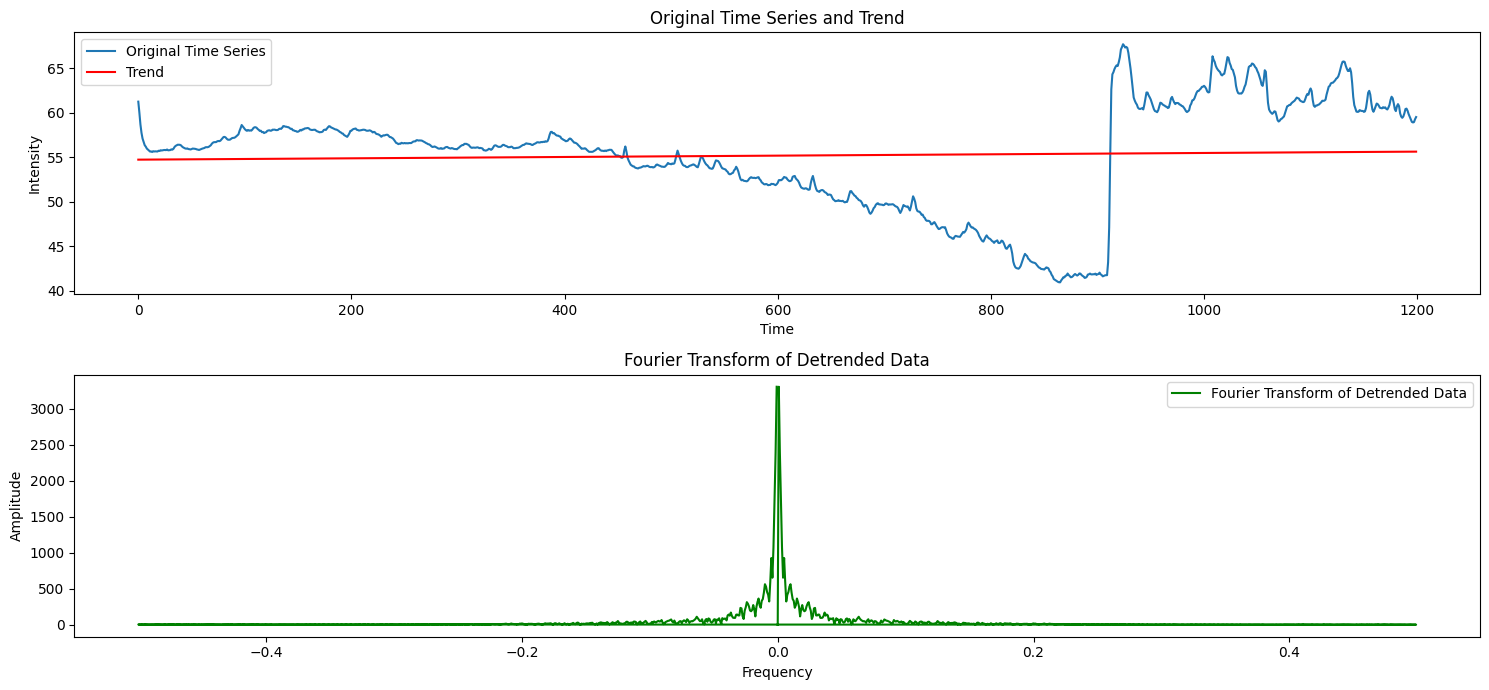

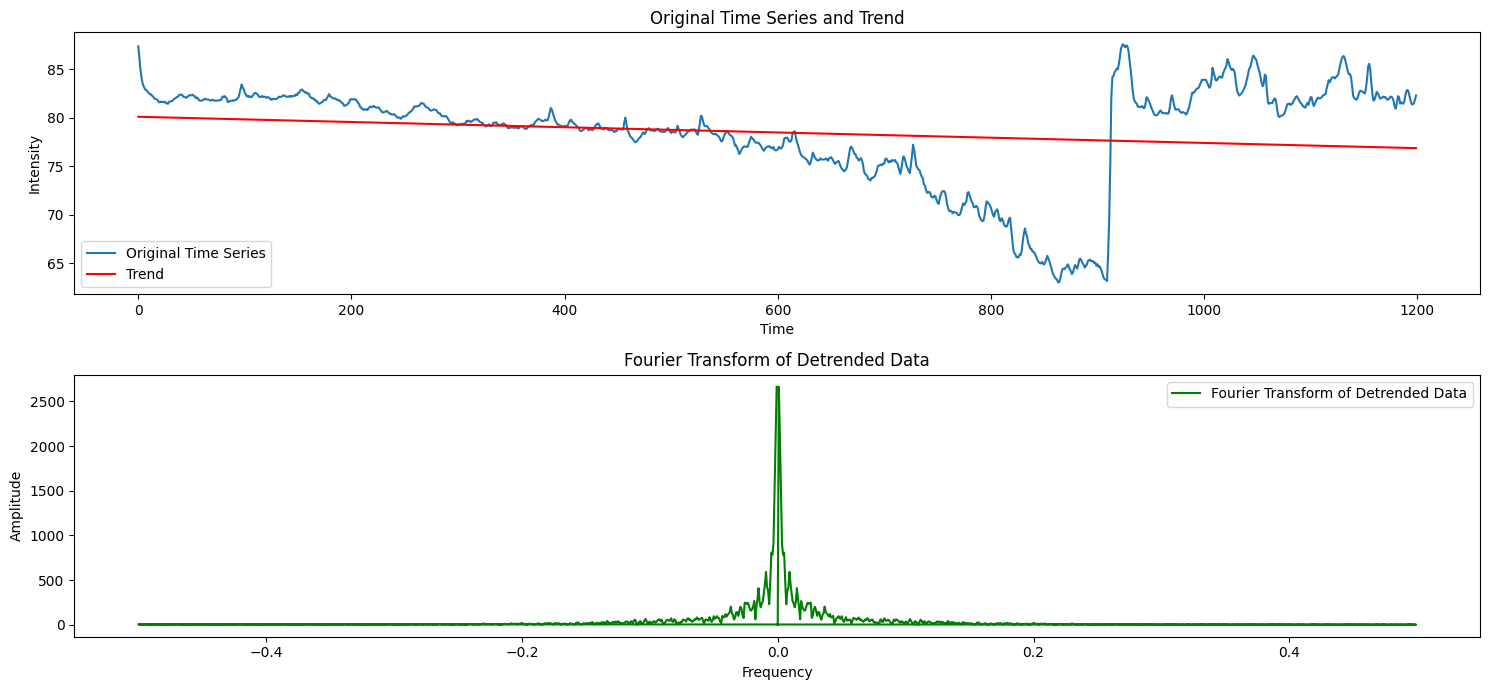

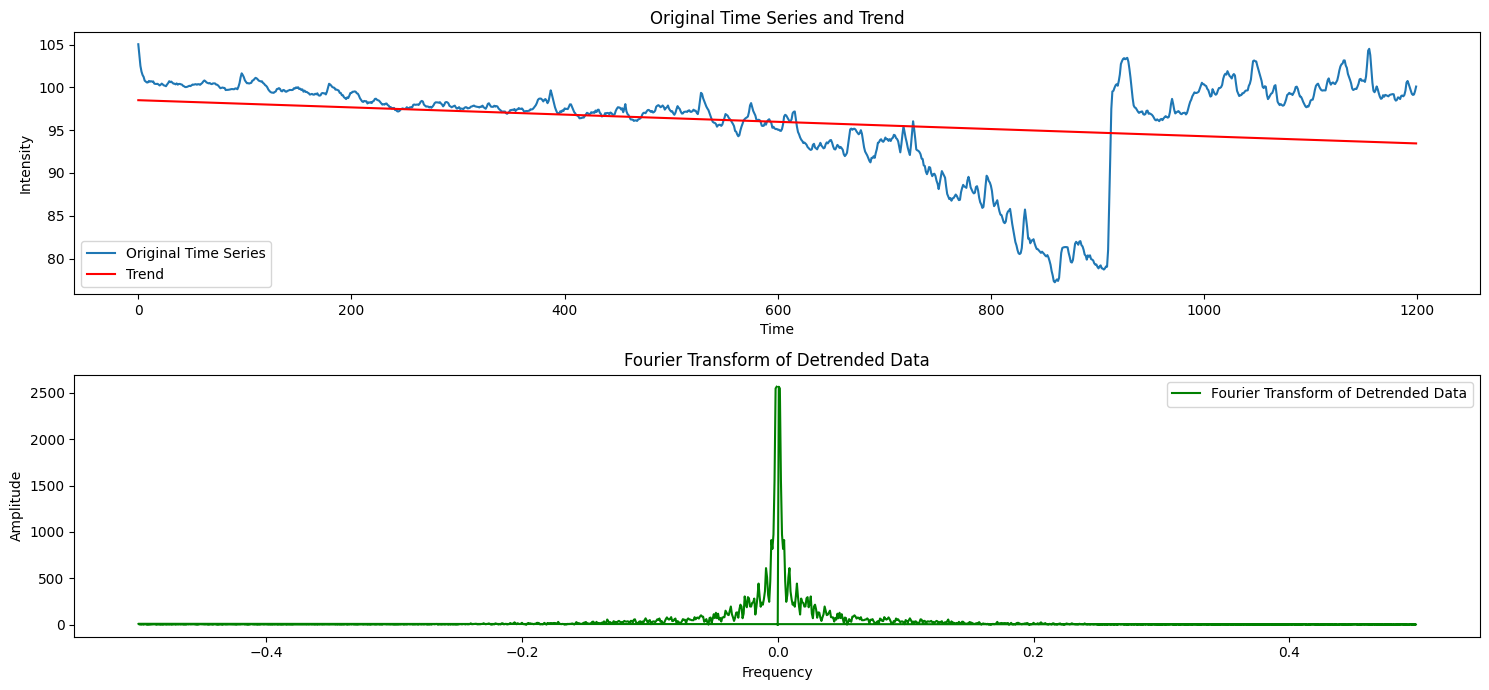

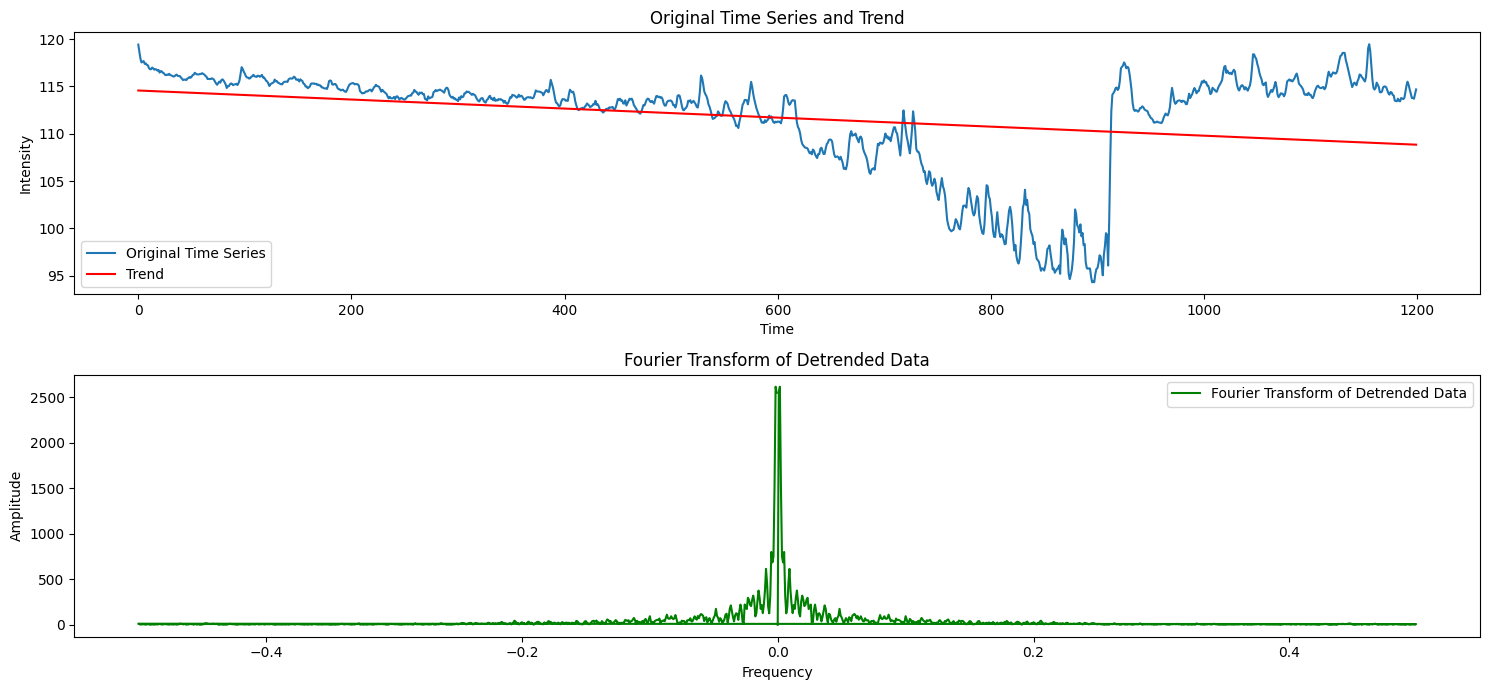

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


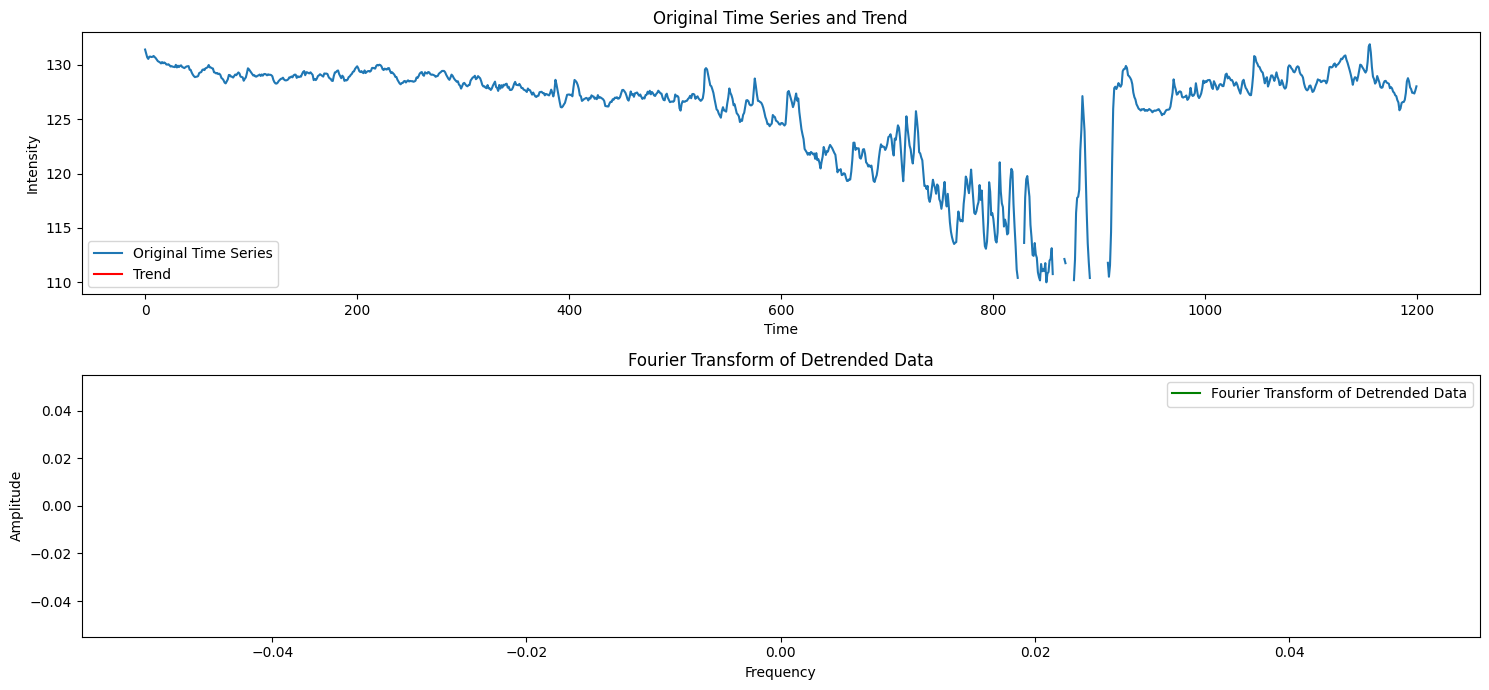

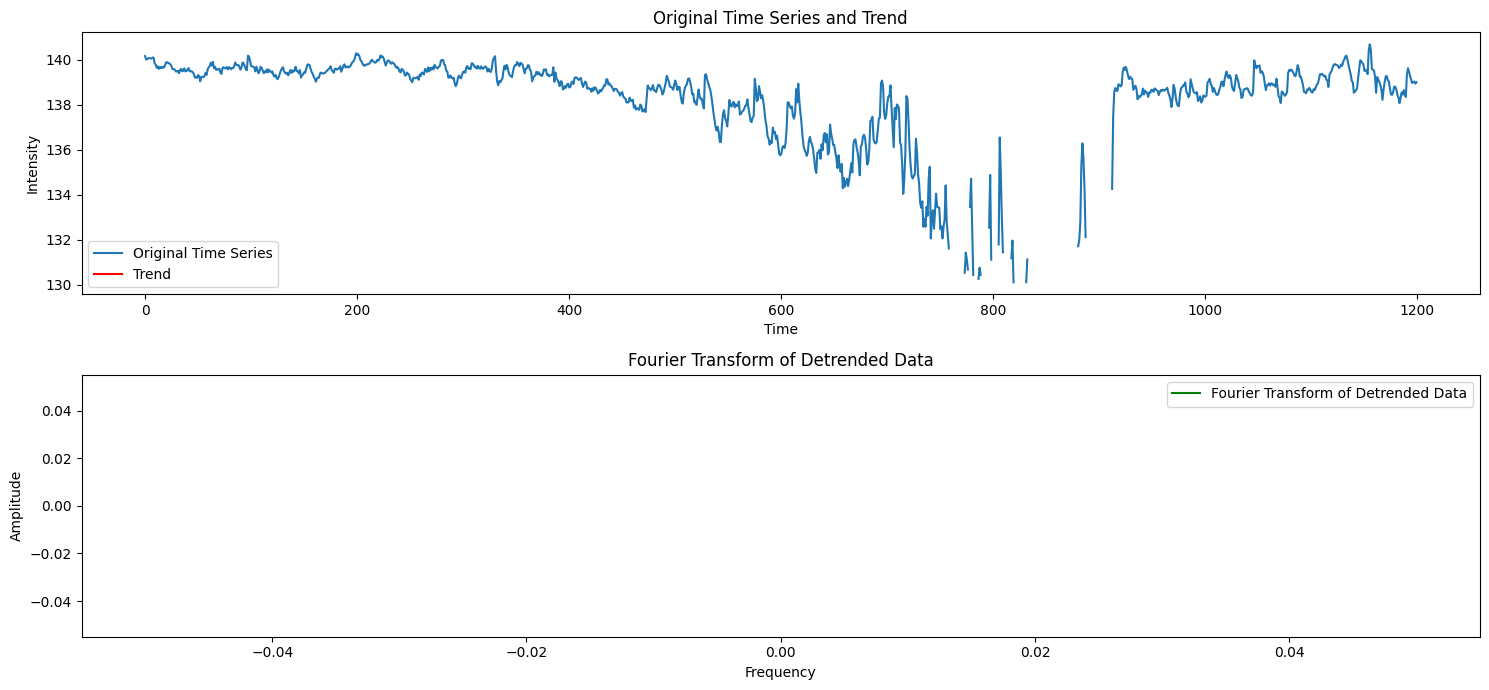

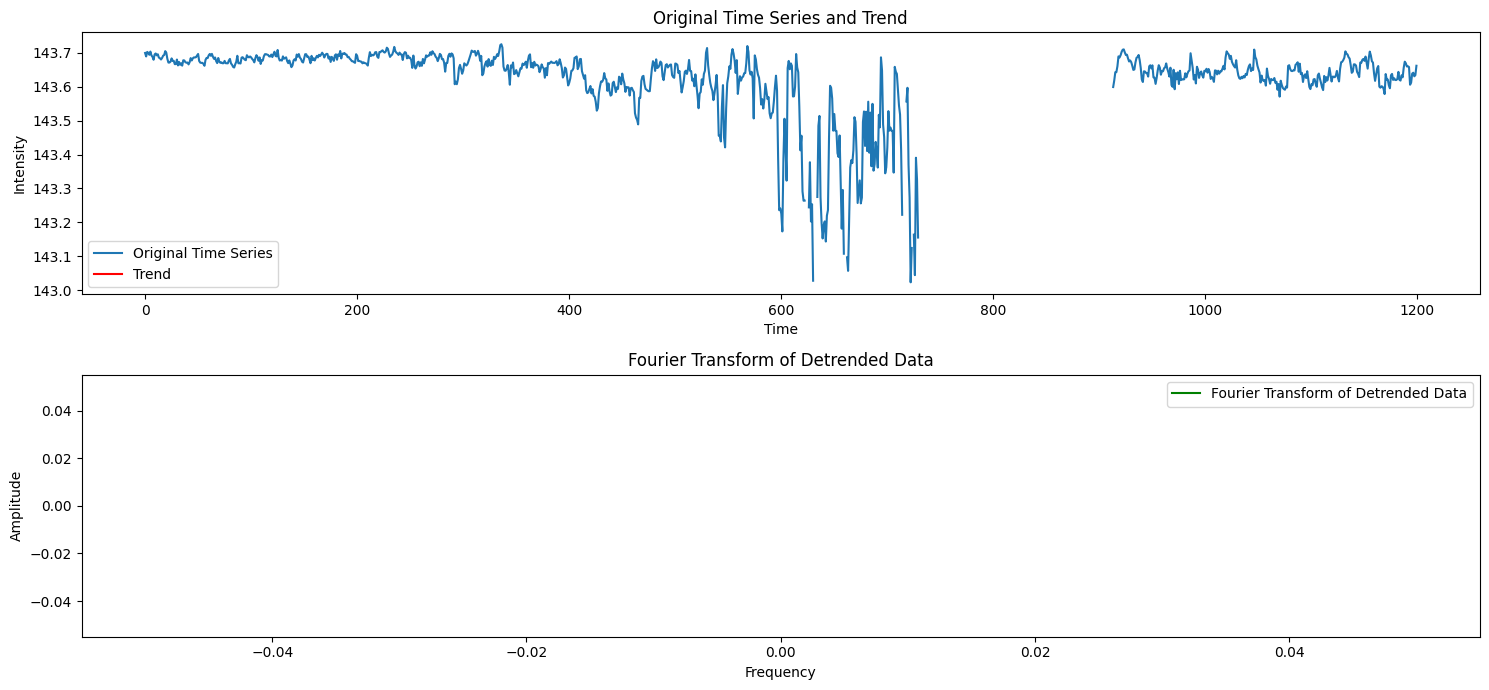

In [15]:
thresholds = [-7, 0, 10, 25, 50, 70, 90, 110, 130, 143]
for threshold in thresholds:
    time_series = intensity_mean(struct, 1024, threshold)
    coefficients = np.polyfit(range(len(time_series)), time_series, 1)
    trend = np.polyval(coefficients, range(len(time_series)))
    detrended_data = time_series - trend

    fft_result_detrended = np.fft.fft(detrended_data)
    frequencies = np.fft.fftfreq(len(detrended_data))

    plt.figure(figsize=(15, 7))

    plt.subplot(2, 1, 1)
    plt.plot(time_series, label='Original Time Series')
    plt.plot(trend, label='Trend', color='red')
    plt.title('Original Time Series and Trend')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(frequencies, np.abs(fft_result_detrended), label='Fourier Transform of Detrended Data', color='green')
    plt.title('Fourier Transform of Detrended Data')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'Fourier Transform of Detrended Data for Threshold {threshold}')
    plt.show()

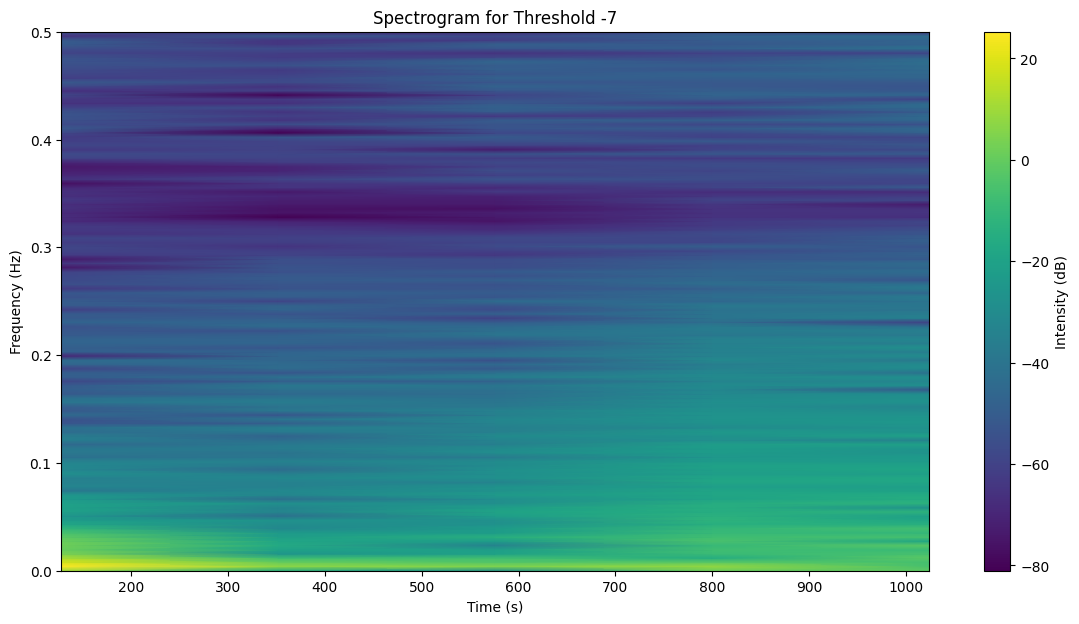

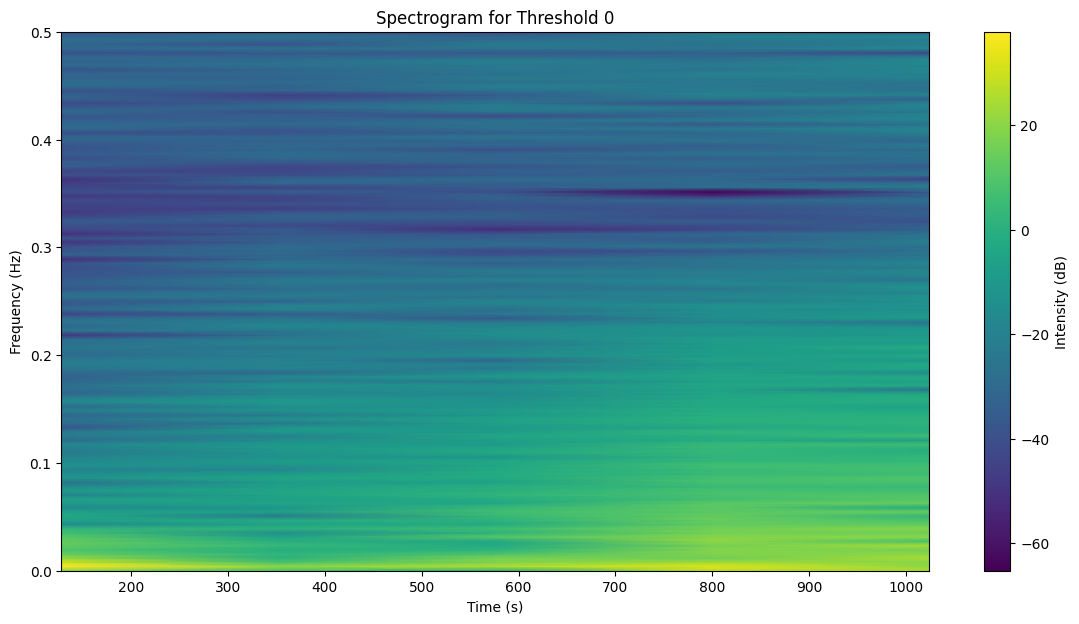

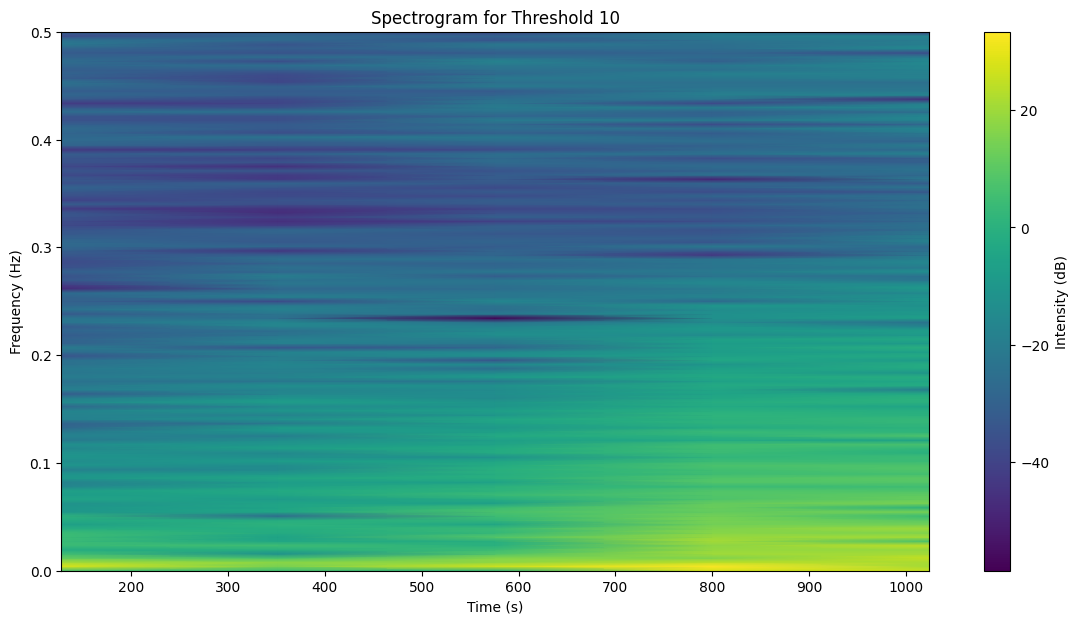

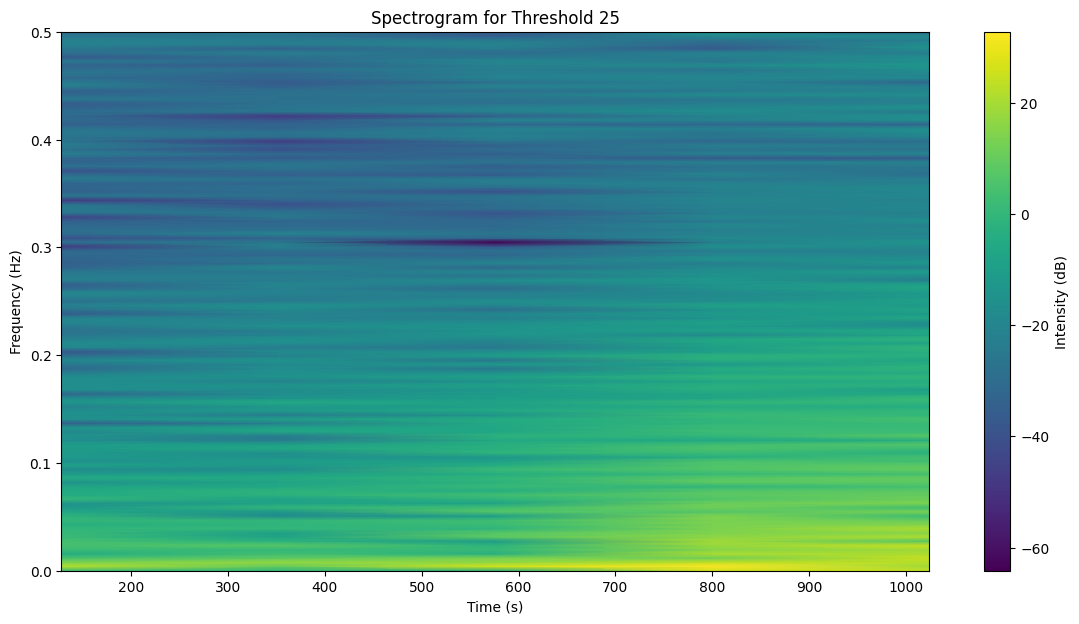

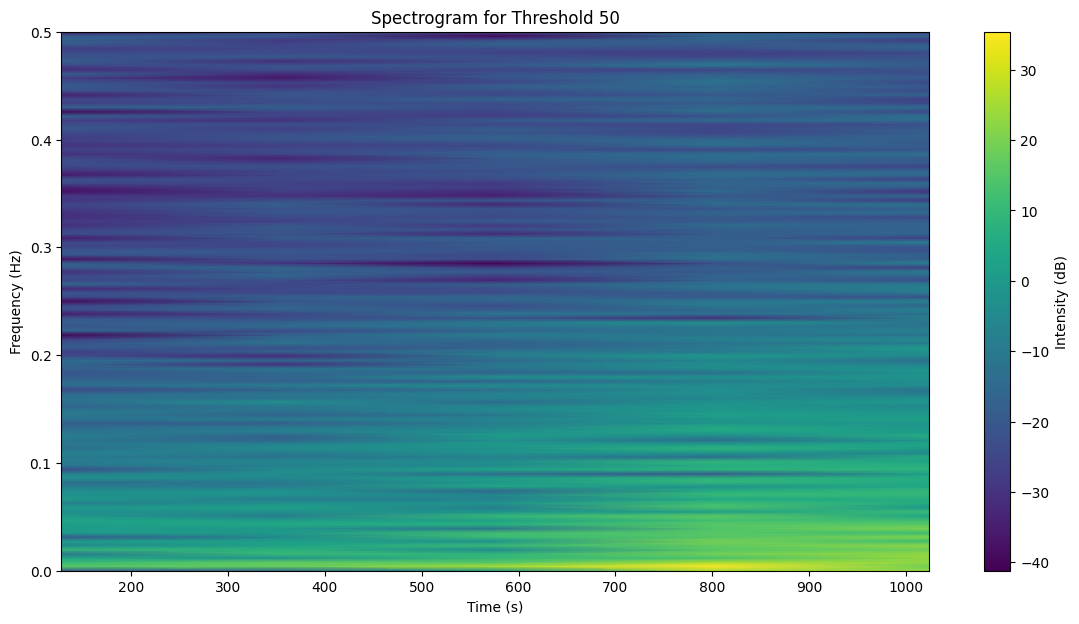

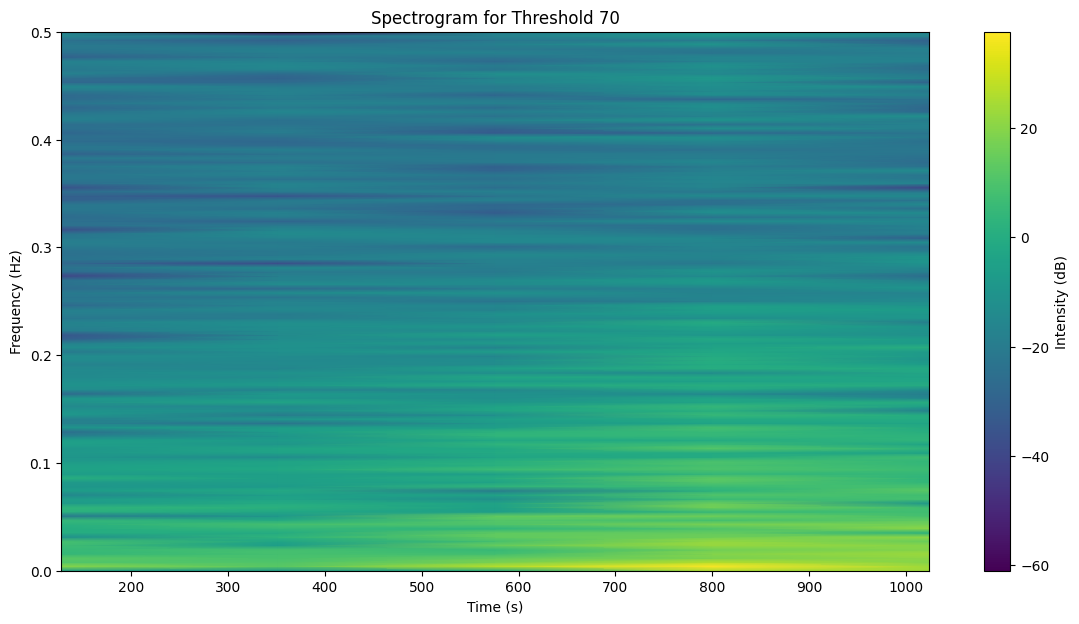

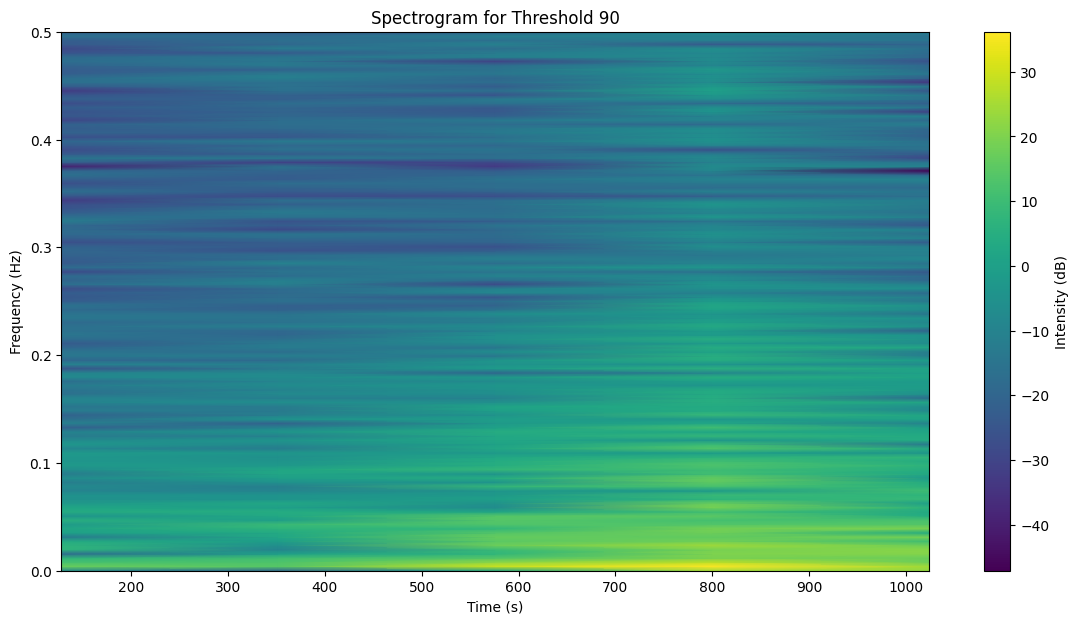

In [20]:
from scipy.signal import spectrogram
thresholds = [-7, 0, 10, 25, 50, 70, 90]
for threshold in thresholds:
    time_series = np.array(intensity_mean(struct, 1024, threshold))
    fs = 1
    frequencies, times, Sxx = spectrogram(time_series, fs)
    plt.figure(figsize=(14, 7))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'Spectrogram for Threshold {threshold}')
    plt.colorbar(label='Intensity (dB)')
    plt.show()